In [ ]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import fitsio
import kcorrect
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append('/home/ygence/kmeans_radec') # If you want to use kmeansradec, modify for your package file, otherwise comment out this and the line below
import kmeans_radec as krad
import h5py
from scipy.optimize import curve_fit

import seaborn as sns
sns.set_theme('talk')
sns.set_style('whitegrid', {'xtick.bottom':True, 'ytick.left':True})
sns.plotting_context('talk')

H0 = 100
Om0=0.3065
Ode0 = 1-Om0
sch_c = 2.99792458e5
ulim = 0.22
bands=['g','r','i','z']
A = 4*np.pi/3 * 4946/41253

### Functions

In [ ]:
def lumdist(z):
    '''
    Calculates the luminosity distance based on given redshift. Uses cubic spline to approximate the result.

    Arguments:
        z: The redshift should be input as a Numpy array

    '''
    z = np.array(z)
    z_max = z.max()

    reds = np.linspace(0,z_max,1000)
    zez = []
    for i in reds:
        zaz = sp.integrate.quad(lambda x:(1/np.sqrt(Om0*(1+x)**3 + Ode0)), 0, i)[0]
        zez.append(zaz)

    return (1+z) * 2.99792458*10**5/H0 * sp.interpolate.interp1d(reds, zez)(z)

def lumdist_err(z,z_err):
    '''
    Calculates the associated upper and lower luminosity distance error based on the given redshift and associated error. 
    The reason for separate errors is that since redshift isn't linearly related to luminosity distance, the transformation doesn't result in the same amount of error.

    Arguments:
        Input: Should be given as a Numpy array
        Output: Numpy array in the form [lower error, upper error]
    
    '''
    z = np.array(z)
    z_err = np.array(z_err)
    
    lowerr = lumdist(z) - lumdist(z-z_err)
    uperr = lumdist(z+z_err) - lumdist(z)

    return np.array([lowerr,uperr])

def z_from_dl(dl):
    '''
    Returns the redshift based on the given luminosity distance in units of Mpc.

    Arguments:
        dl: The luminosity distance should be input as a Numpy array
    
    '''
    dl = np.array(dl)
    reds = np.linspace(0,10,1000)
    zez = []
    for i in reds:
        zaz = (1+i) * 2.99792458*10**5/H0 * sp.integrate.quad(lambda x:(1/np.sqrt(Om0*(1+x)**3 + Ode0)), 0, i)[0]
        zez.append(zaz)

    return sp.interpolate.CubicSpline(zez,reds)(dl)

def E(x):
    return 1/(np.sqrt(Ode0 + Om0 * (1+x)**3))

#single schechter
def func(x, M_star, alpha, phi):
    return 0.4*np.log(10)*phi*10**(-0.4*(1+alpha)*(x-M_star))*np.exp(-1*(10)**(-0.4*(x-M_star)))

#double schechter
def doubfunc(x, M_star, alpha1, phi1, alpha2, phi2):
    return 0.4*np.log(10)*(phi1*10**(-0.4*(1+alpha1)*(x-M_star))+phi2*10**(-0.4*(1+alpha2)*(x-M_star)))*np.exp(-1*(10)**(-0.4*(x-M_star)))

def colorcorr(bandname, redshift, colv, colv1, colm, colm1):
    """
    Calculates k-corrections based on Beare-Brown (2014) paper (https://arxiv.org/pdf/1410.8139). Is used for g, r, i, z bands.

    Arguments:
        Input: Should be Numpy arrays or float values!
        bandname: Should be a String, in the form 'x'.
    """
    from scipy.interpolate import CubicSpline
    import numpy as np
    
    bandname=str(bandname)

    z_array = np.array(np.linspace(0,0.5,51))

    coeff_dict = {      'g':np.array((np.array([0.0000,-0.0161,-0.0334,-0.0505,-0.0642,-0.0930,-0.1483,-0.2178,-0.2863,-0.2469,-0.2673, -0.2686,-0.2478,
                                               -0.2101,-0.1466,-0.0999,-0.0810,-0.0662,-0.0553,-0.0450,-0.0346,-0.0253,-0.0165,-0.0073,0.0008,0.0103,
                                                0.0195,0.0272,0.0352,0.0433,0.0498,0.0544,0.0576,0.0530,0.0336, -0.1596,-0.3490,-0.3862,-0.4522,-0.4112,
                                               -0.2755,-0.2729,-0.4159,-0.2909,-0.2102,-0.1557,-0.1158,-0.0963,-0.0869,-0.0689,-0.0515]),
                                     np.array([1.0000,0.9609,0.9318,0.9121,0.8932,0.8968,0.9413,1.0152,1.0950,1.0078,1.0099,0.9839,0.9220,0.8327,0.7121,
                                               0.6052,0.5368,0.4767,0.4237,0.3743,0.3263,0.2819,0.2402,0.1981,0.1578,0.1139,0.0695,0.0270,-0.0163,-0.0588,
                                               -0.0972,-0.1296,-0.1585,-0.1635,-0.1229,1.0195,1.1784,1.1818,1.2146,1.1259,0.9552,0.8673,0.9411,0.7830,0.6659,
                                               0.5740,0.4960,0.4440,0.4000,0.3441,0.2927]),
                                     np.array([0.0000,0.0146,0.0243,0.0279,0.0292,0.0227,0.0009,-0.0347,-0.0753,-0.0544,-0.0641,-0.0638,-0.0493,-0.0229,
                                               0.0087,0.0436,0.0697,0.0928,0.1142,0.1345,0.1551,0.1749,0.1936,0.2134,0.2334,0.2559,0.2795,0.3032,0.3283,
                                               0.3538,0.3784,0.3999,0.4195,0.4210,0.3873,0.2986,0.2528,0.2437,0.2282,0.2466,0.2786,0.3045,0.2938,0.3268,
                                               0.3523,0.3734,0.3927,0.4057,0.4169,0.4330,0.4475]))),

                        'r':np.array((np.array([-0.0910, -0.0938, -0.0946, -0.0911, -0.0826, -0.0609, -0.0361, -0.0090, -0.0103,-0.0112, -0.0148, -0.0141,
                                                -0.0156, -0.0193, -0.0170, -0.0236, -0.0558, -0.0356,-0.0162, -0.0146, -0.0115, -0.0093, -0.0074, -0.0078,
                                                -0.0148, -0.0360, 0.0184,0.0653, 0.0985, 0.1173, 0.1263, 0.1274, 0.1221, 0.1106, 0.0937, 0.0690, 0.0291,
                                                -0.0337, -0.0442, -0.0621, -0.0626, -0.0637, -0.1234, -0.1298, -0.1229, -0.1148,-0.1050, -0.0889, -0.0796,
                                                -0.0852, -0.0819]),
                                     np.array([0.5390, 0.5250, 0.5045, 0.4742, 0.4325, 0.3587, 0.2782, 0.1915, 0.1717, 0.1553,0.1479,0.1297,0.1183,0.1174,
                                                0.1024, 0.1181, 0.2072, 0.1366, 0.0696, 0.0593,0.0465, 0.0369, 0.0282, 0.0277, 0.0515, 0.1261, 0.2922, 0.1758,
                                                0.0850, 0.0219,-0.0214, -0.0476, -0.0599, -0.0574, -0.0431, -0.0151, 0.0483, 0.1584, 0.1685, 0.1963, 0.1862,
                                                0.1849, 0.3061, 0.3129, 0.2957, 0.2770, 0.2525, 0.2133, 0.1930, 0.2053, 0.1973]),
                                     np.array([-0.1256, -0.1223, -0.1114, -0.0927, -0.0652, -0.0155, 0.0381, 0.0949, 0.1103, 0.1200, 0.1225, 0.1324, 0.1383,
                                                0.1363, 0.1448, 0.1279, 0.0577, 0.1118, 0.1616, 0.1663, 0.1724, 0.1763, 0.1794, 0.1736, 0.1437, 0.0672, 0.2477,
                                                0.3068, 0.3544,0.3891, 0.4145, 0.4303, 0.4376, 0.4358, 0.4273, 0.4136, 0.3800, 0.3236, 0.3161, 0.2983, 0.3020,
                                                0.2960, 0.2260, 0.2200, 0.2245, 0.2294, 0.2388, 0.2569, 0.2615, 0.2486, 0.2473]))),

                        'i':np.array((np.array([0.0584,0.0531,0.0483,0.0280,-0.0154,-0.0483,-0.0520,-0.0532,-0.0518,-0.0394,-0.0177,0.0045,0.0193,0.0237,
                                               0.0222,0.0183,0.0136,0.0089,0.0044,0.0007,-0.0027,-0.0049,-0.0037,0.0070,0.0325,0.0780,0.1457,0.1765,0.2327,
                                               0.2633,0.2812,0.2876,0.3302,0.3467,0.4001,0.4973,0.5611,0.4876,0.4757,0.4459,0.4466,0.4382,0.3434,0.3134,0.3047,
                                               0.2978,0.2941,0.3018,0.2944,0.2588,0.2414]),
                                     np.array([0.2701,0.2604,0.2614,0.2841,0.3320,0.3548,0.3359,0.3140,0.2890,0.2501,0.1989,0.1474,0.1070,0.0809,0.0634,0.0497,
                                               0.0376,0.0264,0.0154,0.0036,-0.0088,-0.0243,-0.0472,-0.0886,-0.1582,-0.2640,-0.4124,-0.5175,-0.6439,-0.7231,-0.7765,
                                               -0.8052,-0.8873,-0.9233,-1.0185,-1.1916,-1.3055,-1.1735,-1.1600,-1.1105,-1.1270,-1.1115,-0.9172,-0.8648,-0.8536,-0.8452,
                                               -0.8466,-0.8742,-0.8621,-0.7868,-0.7528]),
                                     np.array([0.0916,0.0941,0.0885,0.0748,0.0549,0.0477,0.0555,0.0646,0.0753,0.0916,0.1124,0.1330,0.1495,0.1609,0.1688,0.1744,0.1789,
                                               0.1831,0.1867,0.1906,0.1954,0.2021,0.2134,0.2345,0.2703,0.3249,0.4014,0.4707,0.5386,0.5844,0.6167,0.6346,0.6683,0.6807,
                                               0.7154,0.7848,0.8272,0.7628,0.7577,0.7342,0.7478,0.7369,0.6328,0.6104,0.6078,0.6060,0.6116,0.6322,0.6258,0.5852,0.5675]))),

                        'z':np.array((np.array([0.0000,-0.0022,-0.0037,-0.0031,0.0045,0.0158,0.0230,0.0299,0.0373,0.0396,0.0322,0.0151,-0.0043,-0.0178,-0.0256,
                                               -0.0294,-0.0318,-0.0324,-0.0318,-0.0310,-0.0304,-0.0281,-0.0223,-0.0067,0.0254,0.0142,0.0793,0.1746,0.2307,0.3376,
                                               0.3667,0.4445,0.3563,0.3882,0.4764,0.6360,0.7203,0.6956,0.7300,0.7033,0.7120,0.7995,0.7383,0.6581,0.6363,0.6142,
                                               0.5944,0.5962,0.5671,0.4863,0.4051]),
                                     np.array([0.0000,-0.0134,-0.0282,-0.0487,-0.0795,-0.1135,-0.1408,-0.1673,-0.1930,-0.2078,-0.2064,-0.1914,-0.1731,-0.1634,-0.1620,
                                               -0.1660,-0.1727,-0.1811,-0.1906,-0.2015,-0.2130,-0.2290,-0.2538,-0.2998,-0.3781,-0.4159,-0.5587,-0.7536,-0.8915,-1.0772,
                                               -1.1461,-1.2830,-1.1652,-1.2202,-1.3660,-1.6372,-1.7760,-1.7140,-1.7856,-1.7380,-1.7696,-1.8883,-1.7210,-1.5900,-1.5690,
                                               -1.5461,-1.5253,-1.5502,-1.5021,-1.3411,-1.1830]),
                                     np.array([0.0000,0.0057,0.0124,0.0221,0.0362,0.0501,0.0608,0.0718,0.0828,0.0904,0.0923,0.0891,0.0846,0.0821,0.0816,0.0819,0.0826,
                                               0.0841,0.0853,0.0873,0.0905,0.0963,0.1077,0.1310,0.1716,0.2116,0.2891,0.3912,0.4724,0.5552,0.5947,0.6529,0.6160,0.6344,
                                               0.6875,0.7952,0.8446,0.8033,0.8382,0.8153,0.8378,0.8695,0.7570,0.7078,0.7095,0.7099,0.7109,0.7354,0.7167,0.6413,0.5701]))) }
    
    if bandname in coeff_dict.keys():
        a1 = CubicSpline(z_array, coeff_dict[bandname][0])
        a = a1(redshift)
        
        b1 = CubicSpline(z_array, coeff_dict[bandname][1])
        b = b1(redshift)
        
        c1 = CubicSpline(z_array, coeff_dict[bandname][2])
        c = c1(redshift)
    else:
        print(f'{bandname} not recognised')
    
    if type(redshift)==np.ndarray:
        kc = np.zeros(len(redshift))
        
        if bandname == 'g':
            
            selection_low = (redshift <= 0.34)
            
            if type(colv)==np.ndarray:
                kc[selection_low] = a[selection_low]*(colv[selection_low])**2 + b[selection_low]*colv[selection_low] + c[selection_low] - colm[selection_low]
                kc[~selection_low] = a[~selection_low]*(colv1[~selection_low])**2 + b[~selection_low]*colv1[~selection_low] + c[~selection_low] - colm1[~selection_low]
            
            elif (type(colv)==np.float64) or (type(redshift)==np.float32):
                    kc[selection_low] = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
                    kc[~selection_low] = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1
            
            else:
                raise Exception('No valid color values entered')
    
        elif bandname =='r':
            
            selection_low = (redshift <= 0.25)
            
            if type(colv)==np.ndarray:
                kc[selection_low] = a[selection_low]*(colv[selection_low])**2 + b[selection_low]*colv[selection_low] + c[selection_low] - colm[selection_low]
                kc[~selection_low] = a[~selection_low]*(colv1[~selection_low])**2 + b[~selection_low]*colv1[~selection_low] + c[~selection_low] - colm1[~selection_low]
                
            elif (type(colv)==np.float64) or (type(redshift)==np.float32):
                    kc[selection_low] = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
                    kc[~selection_low] = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1

            else:
                raise Exception('No valid color values entered')
    
        elif bandname=='i':
            kc = a*(colv)**2 + b*(colv) + c - colm
        
        elif bandname=='z':
            kc = a*(colv)**2 + b*(colv) + c
    
        else:
            raise Exception(f'{bandname} not recognised')
            
    elif (type(redshift)==np.float64) or (type(redshift)==np.float32):
        if bandname == 'g':
        
            selection_low = (redshift <= 0.34)
            
            if redshift <= 0.34:
                kc = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
            else:
                kc = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1
    
        elif bandname =='r':
            
            selection_low = (redshift <= 0.25)
            
            if redshift <= 0.25:
                kc = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
            else:
                kc = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1
    
        elif bandname=='i':
            kc = a*(colv)**2 + b*(colv) + c - colm
        
        elif bandname=='z':
            kc = a*(colv)**2 + b*(colv) + c
    
        else:
            raise Exception(f'{bandname} not recognised')
    else:
        raise Exception('Invalid Redshift')
    
    return kc

def absmag(redshift, appmag_g, appmag_r, appmag_i, appmag_z):
    '''
    Calculates the absolute magnitudes from the given redshift values, using the k-corrections computed with the Beare method.
    
    Arguments:
        Input: Should be Numpy arrays!
        Returns: Four arrays, each containing absolute magnitudes in the bands g,r,i,z respectively.

    '''
    # g-band
    colv = appmag_g - appmag_r
    colv1 = appmag_r - appmag_i
    colm = colv
    colm1 = appmag_g - appmag_i
    
    abs_g = colorcorr('g', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_g 

    # r-band
    colv = appmag_g - appmag_i
    colv1 = appmag_r - appmag_z
    colm = appmag_r - appmag_i
    colm1 = appmag_r - appmag_z
    
    abs_r = colorcorr('r', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_r

    # i-band
    colv = appmag_r - appmag_z
    colv1 = 0
    colm = appmag_i - appmag_z
    colm1 = 0
    
    abs_i = colorcorr('i', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_i

    # z-band
    colv = appmag_r - appmag_z
    colv1 = 0
    colm = 0
    colm1 = 0
    abs_z = colorcorr('z', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_z
         
    absmag = np.array([abs_g,abs_r,abs_i,abs_z])

    return absmag

def z_max_finder(mag_g, mag_r, mag_i, mag_z, M):
    '''
    Calculates the z max for each galaxy in each band, as described in the Eales method paper: https://articles.adsabs.harvard.edu/pdf/1993ApJ...404...51E.
    
    Arguments:
        mags: Should be Numpy arrays for each band!
        M: Absolute magnitude array with all bands in order of (g,r,i,z)
        Returns: 
        z_max: Four arrays, each containing z max in the bands g,r,i,z respectively.
        unfit: Four lists, each containing object IDs that are not visible in the entire magnitude range of the DES Y3 survey, so they need to be exluded.

    '''

    from scipy.interpolate import CubicSpline
    uplim = ulim
    bruh = int(4000*uplim)
    redrange = np.linspace(1e-6, uplim, bruh)
    z_array = np.array(np.linspace(0,0.5,51))
    dl = lumdist(redrange)
    
    coeff_dict = {      'g':np.array((np.array([0.0000,-0.0161,-0.0334,-0.0505,-0.0642,-0.0930,-0.1483,-0.2178,-0.2863,-0.2469,-0.2673, -0.2686,-0.2478,
                                               -0.2101,-0.1466,-0.0999,-0.0810,-0.0662,-0.0553,-0.0450,-0.0346,-0.0253,-0.0165,-0.0073,0.0008,0.0103,
                                                0.0195,0.0272,0.0352,0.0433,0.0498,0.0544,0.0576,0.0530,0.0336, -0.1596,-0.3490,-0.3862,-0.4522,-0.4112,
                                               -0.2755,-0.2729,-0.4159,-0.2909,-0.2102,-0.1557,-0.1158,-0.0963,-0.0869,-0.0689,-0.0515]),
                                     np.array([1.0000,0.9609,0.9318,0.9121,0.8932,0.8968,0.9413,1.0152,1.0950,1.0078,1.0099,0.9839,0.9220,0.8327,0.7121,
                                               0.6052,0.5368,0.4767,0.4237,0.3743,0.3263,0.2819,0.2402,0.1981,0.1578,0.1139,0.0695,0.0270,-0.0163,-0.0588,
                                               -0.0972,-0.1296,-0.1585,-0.1635,-0.1229,1.0195,1.1784,1.1818,1.2146,1.1259,0.9552,0.8673,0.9411,0.7830,0.6659,
                                               0.5740,0.4960,0.4440,0.4000,0.3441,0.2927]),
                                     np.array([0.0000,0.0146,0.0243,0.0279,0.0292,0.0227,0.0009,-0.0347,-0.0753,-0.0544,-0.0641,-0.0638,-0.0493,-0.0229,
                                               0.0087,0.0436,0.0697,0.0928,0.1142,0.1345,0.1551,0.1749,0.1936,0.2134,0.2334,0.2559,0.2795,0.3032,0.3283,
                                               0.3538,0.3784,0.3999,0.4195,0.4210,0.3873,0.2986,0.2528,0.2437,0.2282,0.2466,0.2786,0.3045,0.2938,0.3268,
                                               0.3523,0.3734,0.3927,0.4057,0.4169,0.4330,0.4475]))),
                        'r':np.array((np.array([-0.0910, -0.0938, -0.0946, -0.0911, -0.0826, -0.0609, -0.0361, -0.0090, -0.0103,-0.0112, -0.0148, -0.0141,
                                                -0.0156, -0.0193, -0.0170, -0.0236, -0.0558, -0.0356,-0.0162, -0.0146, -0.0115, -0.0093, -0.0074, -0.0078,
                                                -0.0148, -0.0360, 0.0184,0.0653, 0.0985, 0.1173, 0.1263, 0.1274, 0.1221, 0.1106, 0.0937, 0.0690, 0.0291,
                                                -0.0337, -0.0442, -0.0621, -0.0626, -0.0637, -0.1234, -0.1298, -0.1229, -0.1148,-0.1050, -0.0889, -0.0796,
                                                -0.0852, -0.0819]),
                                     np.array([0.5390, 0.5250, 0.5045, 0.4742, 0.4325, 0.3587, 0.2782, 0.1915, 0.1717, 0.1553,0.1479,0.1297,0.1183,0.1174,
                                                0.1024, 0.1181, 0.2072, 0.1366, 0.0696, 0.0593,0.0465, 0.0369, 0.0282, 0.0277, 0.0515, 0.1261, 0.2922, 0.1758,
                                                0.0850, 0.0219,-0.0214, -0.0476, -0.0599, -0.0574, -0.0431, -0.0151, 0.0483, 0.1584, 0.1685, 0.1963, 0.1862,
                                                0.1849, 0.3061, 0.3129, 0.2957, 0.2770, 0.2525, 0.2133, 0.1930, 0.2053, 0.1973]),
                                     np.array([-0.1256, -0.1223, -0.1114, -0.0927, -0.0652, -0.0155, 0.0381, 0.0949, 0.1103, 0.1200, 0.1225, 0.1324, 0.1383,
                                                0.1363, 0.1448, 0.1279, 0.0577, 0.1118, 0.1616, 0.1663, 0.1724, 0.1763, 0.1794, 0.1736, 0.1437, 0.0672, 0.2477,
                                                0.3068, 0.3544,0.3891, 0.4145, 0.4303, 0.4376, 0.4358, 0.4273, 0.4136, 0.3800, 0.3236, 0.3161, 0.2983, 0.3020,
                                                0.2960, 0.2260, 0.2200, 0.2245, 0.2294, 0.2388, 0.2569, 0.2615, 0.2486, 0.2473]))),
                        'i':np.array((np.array([0.0584,0.0531,0.0483,0.0280,-0.0154,-0.0483,-0.0520,-0.0532,-0.0518,-0.0394,-0.0177,0.0045,0.0193,0.0237,
                                               0.0222,0.0183,0.0136,0.0089,0.0044,0.0007,-0.0027,-0.0049,-0.0037,0.0070,0.0325,0.0780,0.1457,0.1765,0.2327,
                                               0.2633,0.2812,0.2876,0.3302,0.3467,0.4001,0.4973,0.5611,0.4876,0.4757,0.4459,0.4466,0.4382,0.3434,0.3134,0.3047,
                                               0.2978,0.2941,0.3018,0.2944,0.2588,0.2414]),
                                     np.array([0.2701,0.2604,0.2614,0.2841,0.3320,0.3548,0.3359,0.3140,0.2890,0.2501,0.1989,0.1474,0.1070,0.0809,0.0634,0.0497,
                                               0.0376,0.0264,0.0154,0.0036,-0.0088,-0.0243,-0.0472,-0.0886,-0.1582,-0.2640,-0.4124,-0.5175,-0.6439,-0.7231,-0.7765,
                                               -0.8052,-0.8873,-0.9233,-1.0185,-1.1916,-1.3055,-1.1735,-1.1600,-1.1105,-1.1270,-1.1115,-0.9172,-0.8648,-0.8536,-0.8452,
                                               -0.8466,-0.8742,-0.8621,-0.7868,-0.7528]),
                                     np.array([0.0916,0.0941,0.0885,0.0748,0.0549,0.0477,0.0555,0.0646,0.0753,0.0916,0.1124,0.1330,0.1495,0.1609,0.1688,0.1744,0.1789,
                                               0.1831,0.1867,0.1906,0.1954,0.2021,0.2134,0.2345,0.2703,0.3249,0.4014,0.4707,0.5386,0.5844,0.6167,0.6346,0.6683,0.6807,
                                               0.7154,0.7848,0.8272,0.7628,0.7577,0.7342,0.7478,0.7369,0.6328,0.6104,0.6078,0.6060,0.6116,0.6322,0.6258,0.5852,0.5675]))),
                        'z':np.array((np.array([0.0000,-0.0022,-0.0037,-0.0031,0.0045,0.0158,0.0230,0.0299,0.0373,0.0396,0.0322,0.0151,-0.0043,-0.0178,-0.0256,
                                               -0.0294,-0.0318,-0.0324,-0.0318,-0.0310,-0.0304,-0.0281,-0.0223,-0.0067,0.0254,0.0142,0.0793,0.1746,0.2307,0.3376,
                                               0.3667,0.4445,0.3563,0.3882,0.4764,0.6360,0.7203,0.6956,0.7300,0.7033,0.7120,0.7995,0.7383,0.6581,0.6363,0.6142,
                                               0.5944,0.5962,0.5671,0.4863,0.4051]),
                                     np.array([0.0000,-0.0134,-0.0282,-0.0487,-0.0795,-0.1135,-0.1408,-0.1673,-0.1930,-0.2078,-0.2064,-0.1914,-0.1731,-0.1634,-0.1620,
                                               -0.1660,-0.1727,-0.1811,-0.1906,-0.2015,-0.2130,-0.2290,-0.2538,-0.2998,-0.3781,-0.4159,-0.5587,-0.7536,-0.8915,-1.0772,
                                               -1.1461,-1.2830,-1.1652,-1.2202,-1.3660,-1.6372,-1.7760,-1.7140,-1.7856,-1.7380,-1.7696,-1.8883,-1.7210,-1.5900,-1.5690,
                                               -1.5461,-1.5253,-1.5502,-1.5021,-1.3411,-1.1830]),
                                     np.array([0.0000,0.0057,0.0124,0.0221,0.0362,0.0501,0.0608,0.0718,0.0828,0.0904,0.0923,0.0891,0.0846,0.0821,0.0816,0.0819,0.0826,
                                               0.0841,0.0853,0.0873,0.0905,0.0963,0.1077,0.1310,0.1716,0.2116,0.2891,0.3912,0.4724,0.5552,0.5947,0.6529,0.6160,0.6344,
                                               0.6875,0.7952,0.8446,0.8033,0.8382,0.8153,0.8378,0.8695,0.7570,0.7078,0.7095,0.7099,0.7109,0.7354,0.7167,0.6413,0.5701]))) }
    
    
    ag1 = CubicSpline(z_array, coeff_dict['g'][0])
    ag = ag1(redrange)
    bg1 = CubicSpline(z_array, coeff_dict['g'][1])
    bg = bg1(redrange)
    cg1 = CubicSpline(z_array, coeff_dict['g'][2])
    cg = cg1(redrange)
    
    ar1 = CubicSpline(z_array, coeff_dict['r'][0])
    ar = ar1(redrange)
    br1 = CubicSpline(z_array, coeff_dict['r'][1])
    br = br1(redrange)
    cr1 = CubicSpline(z_array, coeff_dict['r'][2])
    cr = cr1(redrange)
    
    ai1 = CubicSpline(z_array, coeff_dict['i'][0])
    ai = ai1(redrange)
    bi1 = CubicSpline(z_array, coeff_dict['i'][1])
    bi = bi1(redrange)
    ci1 = CubicSpline(z_array, coeff_dict['i'][2])
    ci = ci1(redrange)
    
    az1 = CubicSpline(z_array, coeff_dict['z'][0])
    az = az1(redrange)
    bz1 = CubicSpline(z_array, coeff_dict['z'][1])
    bz = bz1(redrange)
    cz1 = CubicSpline(z_array, coeff_dict['z'][2])
    cz = cz1(redrange)
    
    z_max = [[] for row in range(4)]
    unfit = [[] for row in range(4)]
    
    grcolv = mag_g - mag_r
    ricolv = mag_r - mag_i
    gicolv = mag_g - mag_i
    rzcolv = mag_r - mag_z
    izcolv = mag_i - mag_z
    
    for i in tqdm(range(len(M[0]))):
        
        # g-band
        kg = np.zeros(len(redrange))
        selection_low = (redrange <= 0.34)
        
        kg[selection_low] = ag[selection_low]*(grcolv[i])**2 + bg[selection_low]*grcolv[i] + cg[selection_low] - grcolv[i]
        kg[~selection_low] = ag[~selection_low]*(ricolv[i])**2 + bg[~selection_low]*ricolv[i] + cg[~selection_low] - gicolv[i]
        
        mag = M[0][i] + 25 + 5*np.log10(dl) - kg

        
        idx = np.searchsorted(mag,23.8)
        if idx==len(mag):
            z_max[0].append(uplim)
        elif idx==0:
            unfit[0].append(i)
        else:
            z_max[0].append(redrange[idx])  # CubicSpline(mag,redrange)(23.8))

        # r-band
        kr = np.zeros(len(redrange))
        selection_low = (redrange <= 0.25)
        
        kr[selection_low] = ar[selection_low]*(gicolv[i])**2 + br[selection_low]*gicolv[i] + cr[selection_low] - ricolv[i]
        kr[~selection_low] = ar[~selection_low]*(rzcolv[i])**2 + br[~selection_low]*rzcolv[i] + cr[~selection_low] - rzcolv[i]
    
        mag = M[1][i] + 25 + 5*np.log10(dl) - kr

        idx = np.searchsorted(mag,23.6)
        if idx==len(mag):
            z_max[1].append(uplim)
        elif idx==0:
            unfit[1].append(i)
        else:
            z_max[1].append(redrange[idx])  # CubicSpline(mag,redrange)(23.6))
            
        # i-band
        ki = ai*(rzcolv[i])**2 + bi*(rzcolv[i]) + ci - izcolv[i]
    
        mag = M[2][i] + 25 + 5*np.log10(dl) - ki

        idx = np.searchsorted(mag,23.)
        if idx==len(mag):
            z_max[2].append(uplim)
        elif idx==0:
            unfit[2].append(i)
        else:
            z_max[2].append(redrange[idx])  # CubicSpline(mag,redrange)(23.))
        
        # z-band
        kz = az*(rzcolv[i])**2 + bz*(rzcolv[i]) + cz

        idx = np.searchsorted(mag,22.4)
        mag = M[3][i] + 25 + 5*np.log10(dl) - kz
    
        if idx==len(mag):
            z_max[3].append(uplim)
        elif idx==0:
            unfit[3].append(i)
        else:
            z_max[3].append(redrange[idx])  # CubicSpline(mag,redrange)(22.4))

    z_max = np.array(z_max)
    return z_max, unfit

def decam_to_sdss(m_g, m_r, m_i, m_z):
    # https://arxiv.org/abs/1708.01531
    g_sdss = m_g + 0.060 * (m_g - m_i) - 0.005
    r_sdss = m_r + 0.150 * (m_r - m_i) + 0.014
    i_sdss = m_i + 0.167 * (m_r - m_i) - 0.027
    z_sdss = m_z + 0.054 * (m_r - m_i) - 0.024
    return g_sdss, r_sdss, i_sdss, z_sdss

### Masking and Selection

In [10]:
with h5py.File('/shares/soares-santos.physik.uzh/catalogs/valid_sample_des/des_y3_gold_galaxies.hdf5','r') as f:
    print(f.keys())
    errmask = (f['sigmaz'][:]/f['z'][:] < 1000)
    zlim = (f['z'][:] > 0.02) & (f['z'][:] <= ulim)
    tot = zlim #& errmask
    redshift = f['z'][zlim]
    m_g = f['m_g'][zlim]
    m_r = f['m_r'][zlim]
    m_i = f['m_i'][zlim]
    m_z = f['m_z'][zlim]
    ra  = f['ra'][zlim]
    ra[ra > 180.] -= 360.
    dec = f['dec'][zlim]

mag = decam_to_sdss(m_g, m_r, m_i, m_z)

sch_dl = lumdist(redshift)
total_M = absmag(redshift,mag[0],mag[1],mag[2],mag[3])

<KeysViewHDF5 ['dec', 'm_g', 'm_i', 'm_r', 'm_z', 'ra', 'sigmaz', 'z']>


In [ ]:
#Computing the z maxes along with any 'invisible' objects
z_max,unfit = z_max_finder(mag[0],mag[1],mag[2],mag[3], total_M)

100%|██████████| 4505997/4505997 [10:32<00:00, 7127.94it/s]


In [ ]:
#Sky region creation
X = np.array([ra,dec]).T
cellno = 20

km = krad.kmeans_sample(X, cellno, maxiter=150, tol=1.0e-5)

centers = km.centers
if km.converged == True:
    print('Converged successfully',flush=True)
    pass
elif km.converged == False:
    km = krad.kmeans_sample(X, cellno, maxiter=200, tol=1.0e-5)
    if km.converged == True:
        print('Converged successfully',flush=True)
        pass
    elif km.converged == False:
        raise Exception('failed to converge')

X (4245, 2)  centers (20, 2)  tol=1e-05  maxiter=150
40 iterations  cluster sizes: [242 296 180 222 248  72 227  78 214 232 309 244 234 222 168 249 122 263
 149 274]
X (4505997, 2)  centers (20, 2)  tol=1e-05  maxiter=150
60 iterations  cluster sizes: [231812 301625 202778 253908 238579  81657 214516  85177 212683 231427
 323698 243162 217471 255396 185999 266521 202488 277680 212562 266858]
Converged successfully


In [ ]:
#Since there are supposed to be no unfits in this region (z=0.02 to 0.22), we can just assign all objects
cell = [[] for _ in range(cellno)]
num = np.arange(0,cellno)

eventno = len(redshift)

for i in np.arange(0,eventno-len(unfit[0])):
    cell[km.labels[i]].append(i)

In [ ]:
#1/Vmax calculation, we compute the value at the upper limit early to minimize computation time
survey_area_frac = 4946/41253 * (1/cellno)
IV_max = [[] for row in range(4)]

alt = (4*np.pi/3  *survey_area_frac *((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0.,ulim)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0.,0.02)[0])**3))**-1

for j in tqdm(range(4)):
    for i in z_max[j]:
        if i == ulim:
            IV_max[j].append(alt)
        else:
            IV_max[j].append((4*np.pi/3 *survey_area_frac *((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,i)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0.,0.02)[0])**3))**-1)   # defining Vmax
             
IV_max = [np.array(IV_max[0]), np.array(IV_max[1]), np.array(IV_max[2]), np.array(IV_max[3])]

100%|██████████| 4/4 [00:34<00:00,  8.71s/it]


In [ ]:
# binning the absolute mags in each sky region and weighing them against the 1/Vmax values
binsno = 120
counts_list = [[] for row in range(4)]
optedges_list = [[] for row in range(4)]
edgerange = [[] for row in range(4)]

for k in tqdm(range(4)):
    for i in num:
        absel = (total_M[k][cell[i]] >= -25) & (total_M[k][cell[i]] <= -15.5)
        conts,b = np.histogram(total_M[k][cell[i]][absel], bins=binsno, range=([-25,-15.5]), weights=IV_max[k][cell[i]][absel])
        counts_list[k].append(conts)
        edgerange=b
        edges = 0.5*(b[1:]+b[:-1])
        optedges_list[k].append(edges)
    
counts_list = np.array(counts_list)
edgerange = np.array(edgerange)
optedges_list = np.array(optedges_list)

100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


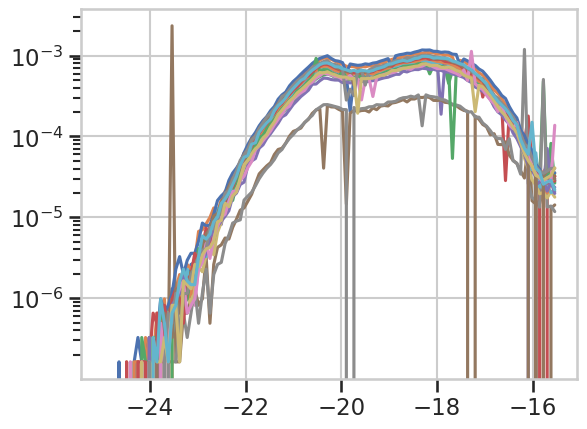

In [10]:
v=1
for i in num:
    plt.plot(optedges_list[v][i],counts_list[v][i])
plt.yscale('log')

In [ ]:
# averaging the sky region distribution in each band

avg_edges = [[] for row in range(4)]
avg_IVmax = [[] for row in range(4)]
sigma_IV  = [[] for row in range(4)]
sigma_opt = [[] for row in range(4)]

for k in range(4):
    for i in tqdm(range(binsno)):
        avg_edges[k].append(np.mean(optedges_list[k][:,i]))
        avg_IVmax[k].append(np.mean(counts_list[k][:,i]))
        
        sigma_opt[k].append(np.std(optedges_list[k][:,i]))
        sigma_IV[k].append(np.std(counts_list[k][:,i]))

avg_edges = np.array(avg_edges)
avg_IVmax = np.array(avg_IVmax)
sigma_IV  = np.array(sigma_IV)
sigma_opt = np.array(sigma_opt)

100%|██████████| 120/120 [00:00<00:00, 19301.17it/s]


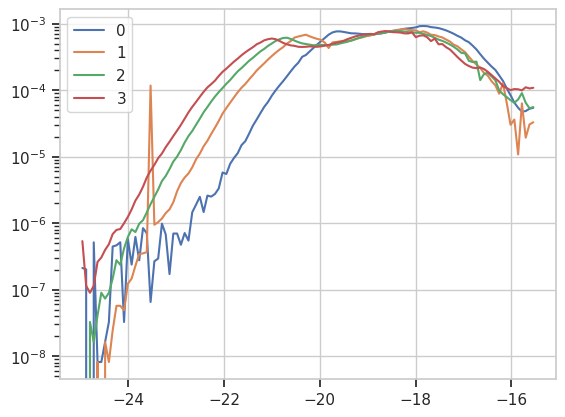

In [ ]:
#Averaged luminosity function estimates in all bands, v values are in order of 'griz' for '0123'.
for v in range(4):
    plt.plot(avg_edges[v],avg_IVmax[v],label=v)
plt.legend()
plt.yscale('log')

In [ ]:
# Using curve fit to fit the Schechter function to the estimated LF

coeffs = []
stddiag = []
Mmin = []
Mmax = []
for i in tqdm(range(4)):
    loval = avg_edges[i][np.where(avg_IVmax[i]==avg_IVmax[i].max())]
    hoval = avg_edges[i][np.where(avg_IVmax[i][avg_edges[i]<loval]==avg_IVmax[i][avg_edges[i]<loval].min())]
    fit_sel = (avg_edges[i] < loval) & (avg_edges[i] > hoval[-1])       # selection
    lim_edges = avg_edges[i][fit_sel]
    lim_IVmax = avg_IVmax[i][fit_sel]

    Mmin.append(loval)
    Mmax.append(hoval)
    
    priors = [-21,-1,1e-3]
    c, cov = curve_fit(func, lim_edges, lim_IVmax, p0=priors, sigma=sigma_IV[i][fit_sel]) #fitting the Schechter function

    stddev = np.sqrt([cov[0,0],cov[1,1],cov[2,2]])
    stdd = [stddev[0],stddev[1],-stddev[2]]

    coeffs.append(c)
    stddiag.append(stdd)

Mmin = np.array([Mmin[0][0],Mmin[1][0],Mmin[2][0],Mmin[3][0]],dtype=object)
Mmax = np.array([Mmax[0][0],Mmax[1][0],Mmax[2][0],Mmax[3][0]],dtype=object)

100%|██████████| 4/4 [00:00<00:00, 612.08it/s]


In [ ]:
# We reload our values for comparison against Blanton (2003), Blanton (2003) uses our amplitude as explained in the thesis
vals = np.genfromtxt('Results/DESY3_z_02_22.txt')
coeffs = vals[0:8:2,0:3]
stddiag = vals[1:9:2,0:3]
Mmin = vals[8]
Mmax = vals[9]

blan_coeffs = [np.array([-19.39, -0.89, coeffs[0][2]]),np.array([-20.44, -1.05, coeffs[1][2]]),np.array([-20.82, -1.0, coeffs[2][2]]),np.array([-21.18, -1.08, coeffs[3][2]])]
blan_stddiag = [[0.02, 0.03, stddiag[0][2]],[0.01, 0.01, stddiag[1][2]],[0.02, 0.02, stddiag[2][2]],[0.02, 0.02, stddiag[3][2]]]

In [ ]:
# kcorrect comparison for differnce in M*

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=100, Om0=0.3065)

appmag = np.array([mag[0],mag[1],mag[2],mag[3]])

flux = 10**(-0.4*appmag)
ivar = 1/(0.4*np.log(10)*flux/100)**2

responses = ['sdss_g1','sdss_r1','sdss_i1','sdss_z1']
kz = kcorrect.kcorrect.Kcorrect(responses=responses,cosmo=cosmo)

coeffs = kz.fit_coeffs(redshift=redshift, maggies=flux.T, ivar=ivar.T)

# getting k corrections
K = kz.kcorrect(redshift=redshift, coeffs=coeffs).T

M_kcorrect = kz.absmag(redshift=redshift, maggies=flux.T, ivar=ivar.T, coeffs=coeffs).T

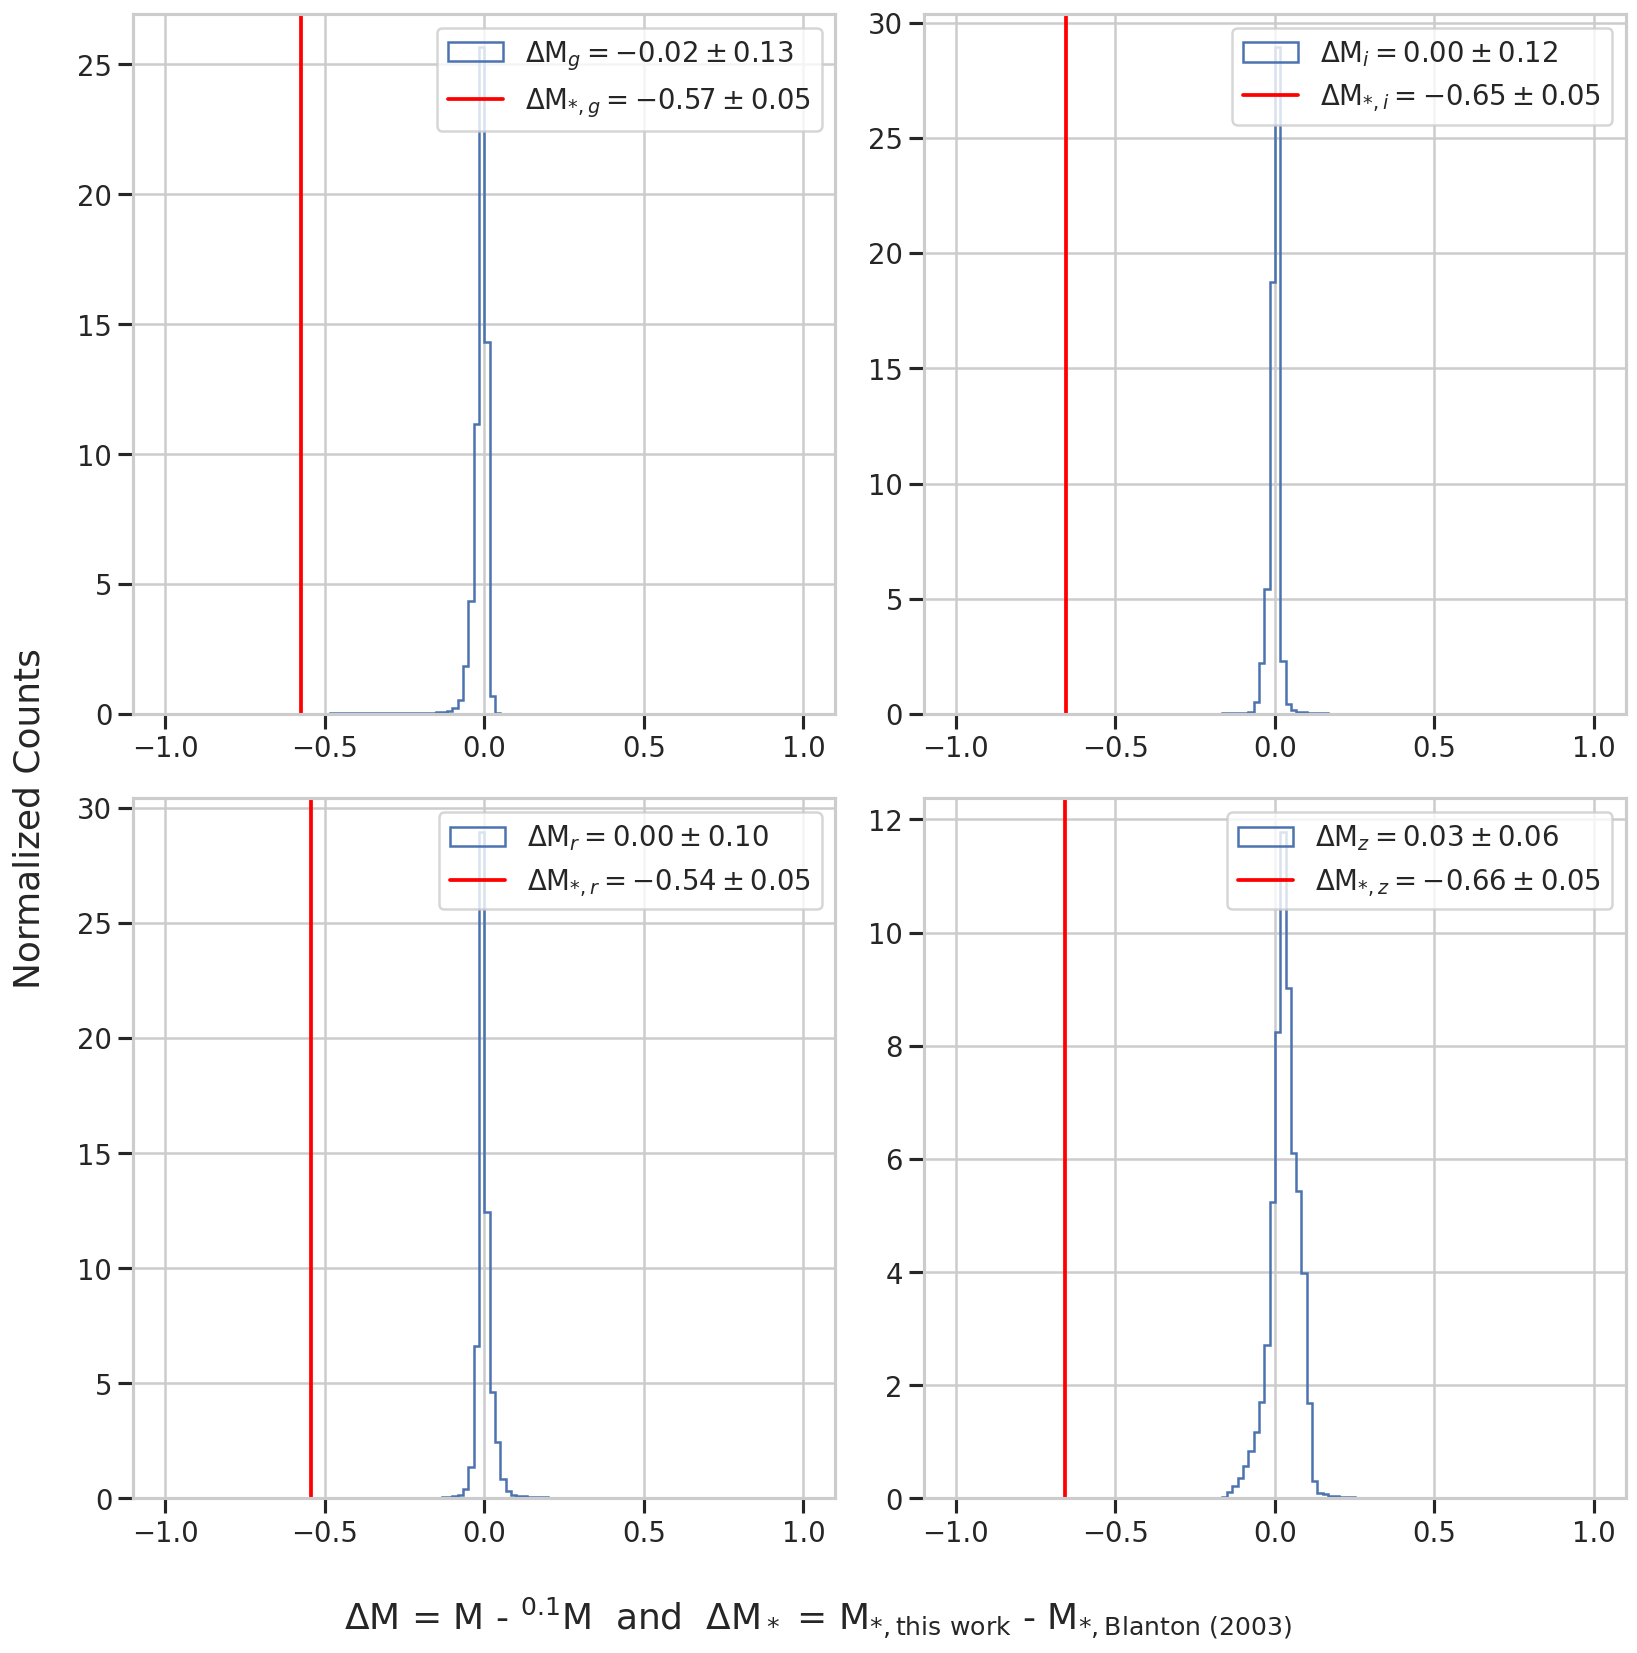

In [ ]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(14,14),dpi=120)
ro = [0,1,0,1]
co = [0,0,1,1]
for b in range(4):
    mean = np.mean(total_M[b]-M_kcorrect[b])
    std = np.std(total_M[b]-M_kcorrect[b])
    diff = coeffs[b][0]-blan_coeffs[b][0]
    difdiag = np.sqrt(stddiag[b][0]**2+blan_stddiag[b][0]**2)
    histt=ax[ro[b]][co[b]].hist(total_M[b]-M_kcorrect[b],bins=120,range=(-1,1),density=True,histtype='step',label=rf'$\Delta$M$_{{{bands[b]}}} = {mean:.2f}\pm{std:.2f}$')
    ax[ro[b]][co[b]].axvline(diff,color='red',label=rf'$\Delta$M$_{{*,{bands[b]}}}={diff:.2f}\pm{difdiag:.2f}$')
    ax[ro[b]][co[b]].legend(loc='upper right')
fig.supylabel('Normalized Counts')
fig.supxlabel(r'$\Delta$M = M - $^{0.1}$M  and  $\Delta$M$_*$ = M$_{*,\text{this work}}$ - M$_{*,\text{Blanton (2003)}}$')
fig.tight_layout()
plt.show()

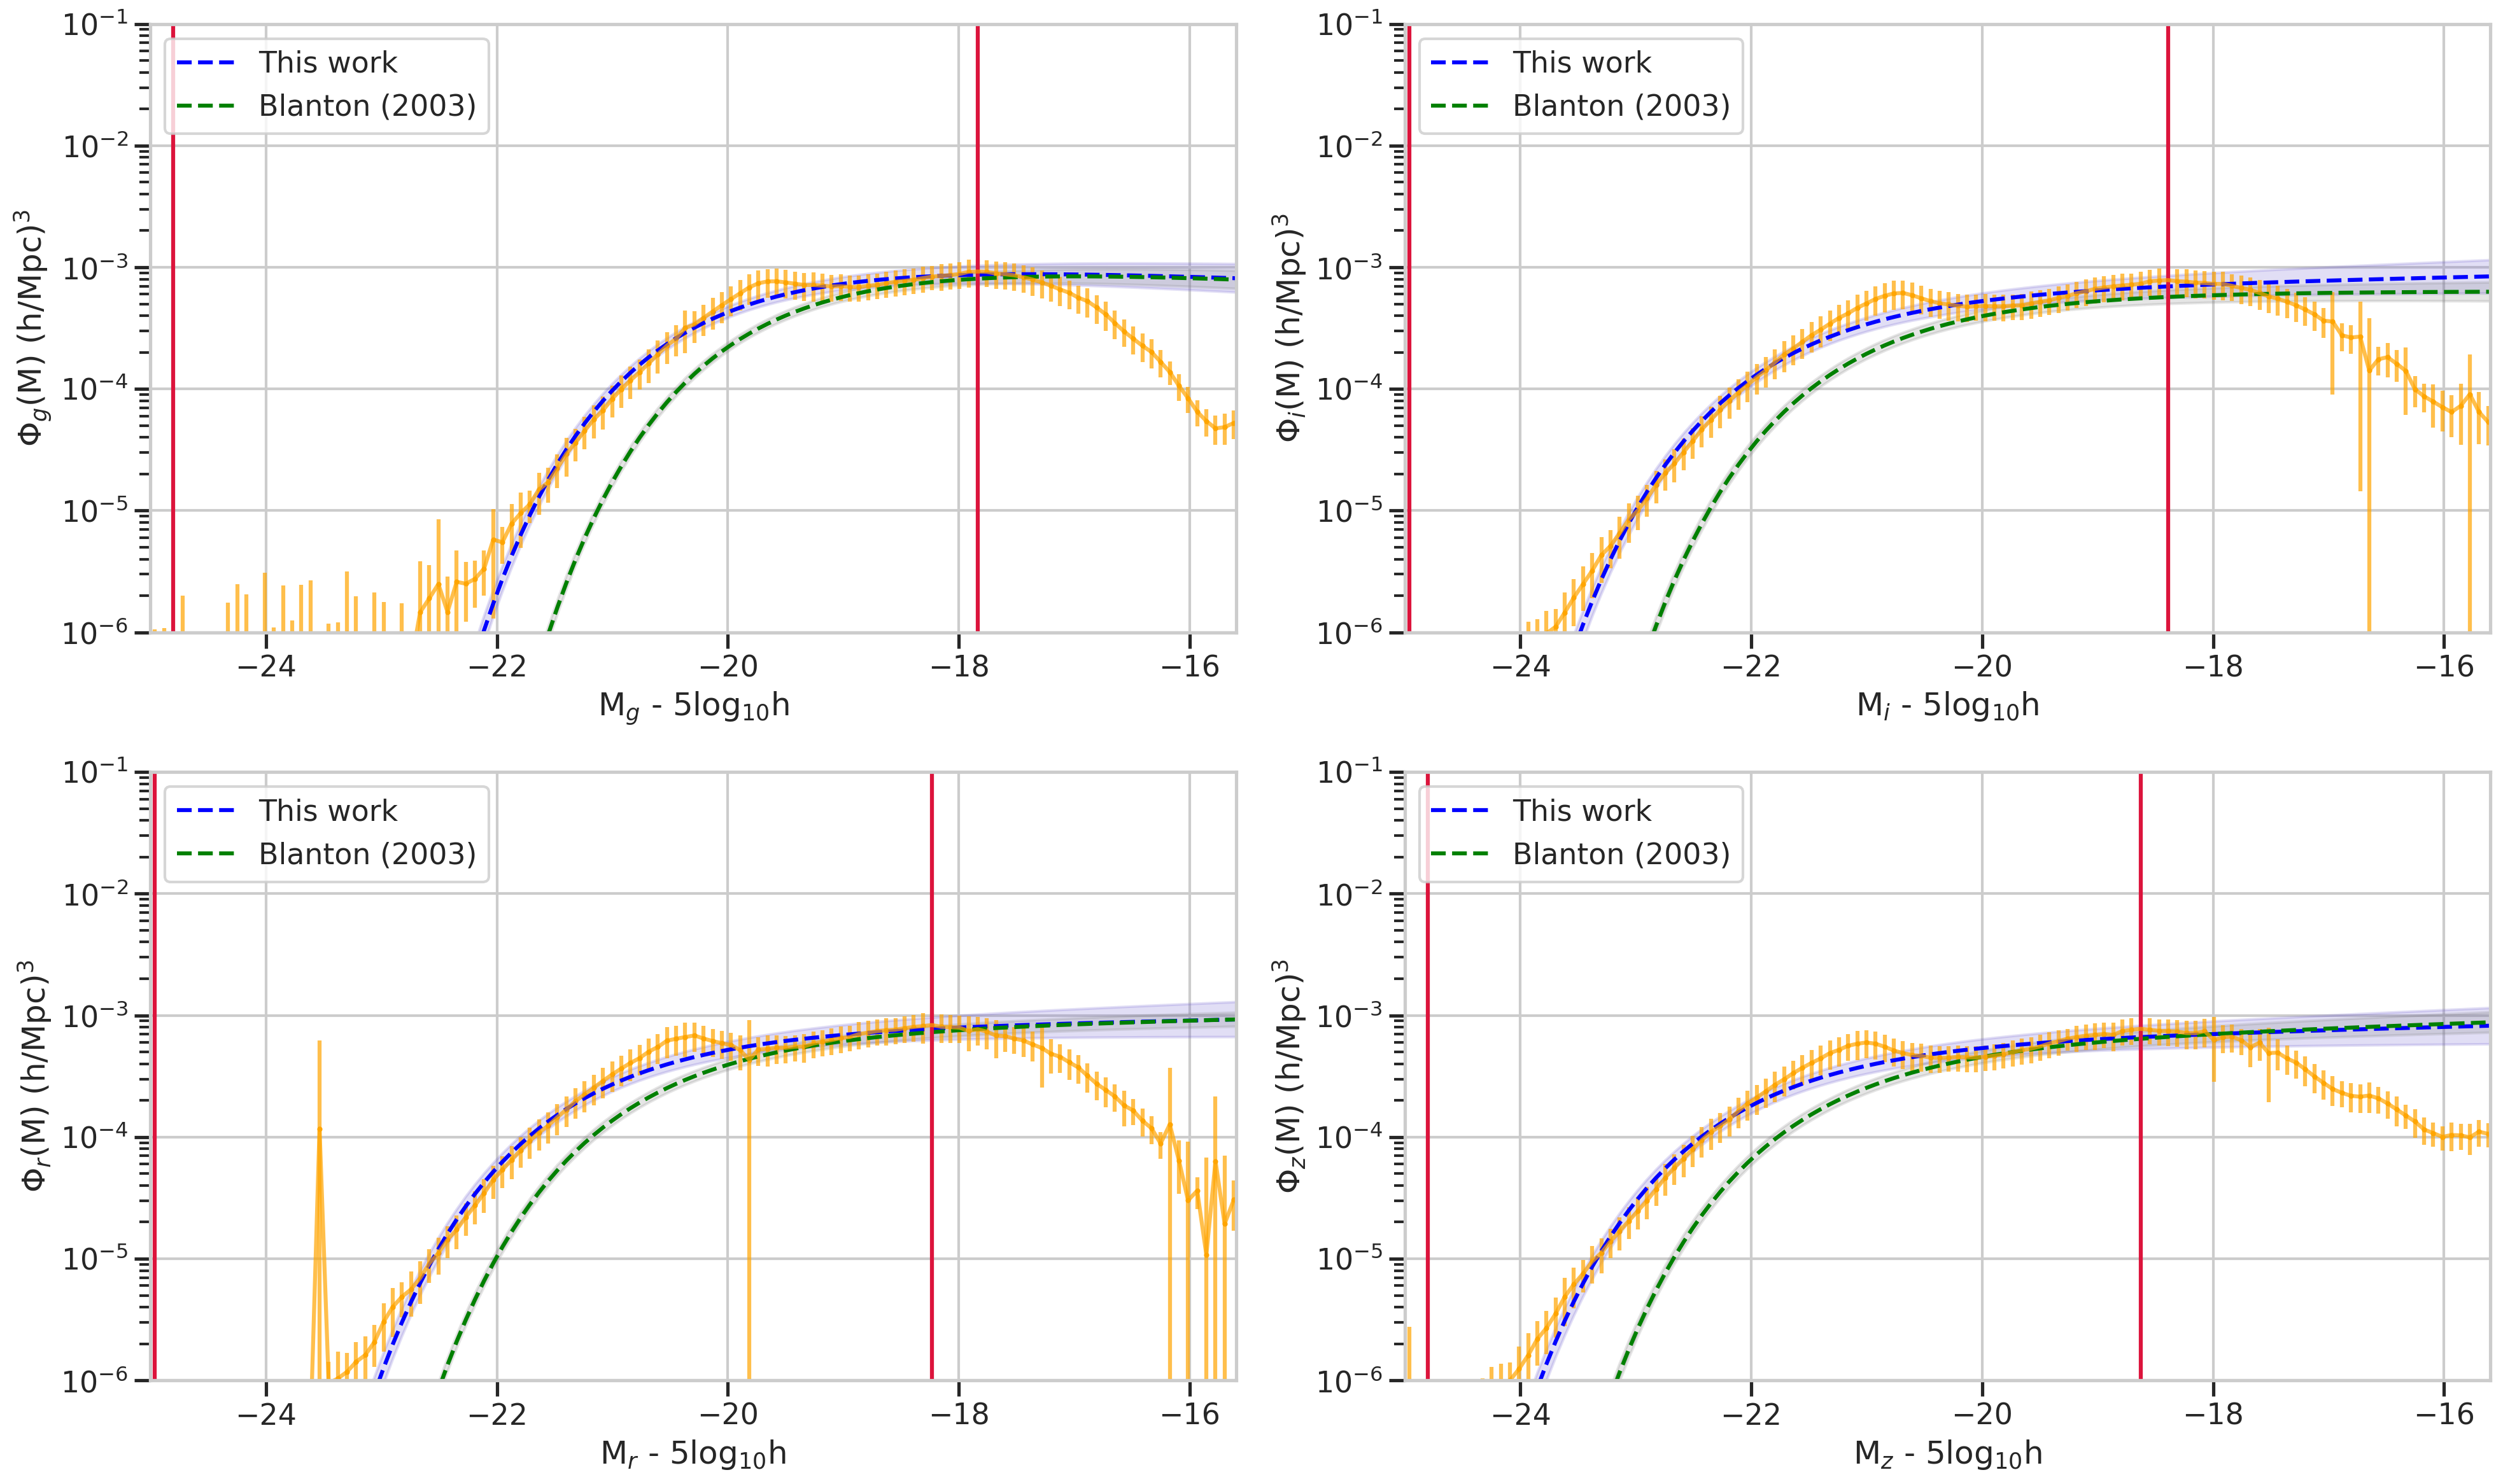

In [ ]:
# Plotting the Schechter function against the data, and Blanton (2003) if so desired
# Switch the commented out plotting lines for this

fig, ax = plt.subplots(dpi=200,nrows=2,ncols=2,figsize=(20,12))
ro = [0,1,0,1]
co = [0,0,1,1]
for i in range(4):
    ax[ro[i]][co[i]].scatter(avg_edges[i], avg_IVmax[i], color='orange',s=2)
    ax[ro[i]][co[i]].errorbar(avg_edges[i], avg_IVmax[i], yerr=sigma_IV[i], alpha=0.7, color='orange')

    #ax[ro[i]][co[i]].plot(avg_edges[i], func(avg_edges[i],*coeffs[i]), color='blue', ls='--', label=[fr'{bands[i]}-band parameters; $\phi_{{*}}$: {coeffs[i][2]:.2e}, M$_{{*}}$: {coeffs[i][0]:.2f}, $\alpha$: {coeffs[i][1]:.2f}'])
    ax[ro[i]][co[i]].plot(avg_edges[i], func(avg_edges[i],*coeffs[i]), color='blue', ls='--', label=f'This work')
    ax[ro[i]][co[i]].fill_between(avg_edges[i],func(avg_edges[i],*(coeffs[i]+stddiag[i])), func(avg_edges[i],*(coeffs[i]-stddiag[i])), alpha=0.2 ,where=(func(avg_edges[i],*(coeffs[i]+stddiag[i]))<func(avg_edges[i],*(coeffs[i]-stddiag[i]))), color='slateblue')

    ax[ro[i]][co[i]].plot(avg_edges[i], func(avg_edges[i],*blan_coeffs[i]), color='green', ls='--', label=f'Blanton (2003)')
    ax[ro[i]][co[i]].fill_between(avg_edges[i],func(avg_edges[i],*(blan_coeffs[i]+blan_stddiag[i])), func(avg_edges[i],*(blan_coeffs[i]-blan_stddiag[i])), alpha=0.2 ,where=(func(avg_edges[i],*(blan_coeffs[i]+blan_stddiag[i]))<func(avg_edges[i],*(blan_coeffs[i]-blan_stddiag[i]))), color='grey')

    ax[ro[i]][co[i]].axvline(Mmin[i],color='crimson') #,label=f'Fitting range:[{Mmax[i]:.2f},{Mmin[i]:.2f}]')
    ax[ro[i]][co[i]].axvline(Mmax[i] ,color='crimson')

    ax[ro[i]][co[i]].set_xlabel(fr'M$_{bands[i]}$ - 5log$_{{10}}$h')
    ax[ro[i]][co[i]].set_ylabel(fr'$\Phi_{bands[i]}$(M) (h/Mpc)$^{{3}}$')

    ax[ro[i]][co[i]].set_yscale('log')
    ax[ro[i]][co[i]].set_xscale('linear')

    ax[ro[i]][co[i]].xaxis_inverted()
    ax[ro[i]][co[i]].set_xbound(-25,-15.6)           #enable to see a close-up
    ax[ro[i]][co[i]].set_ybound(1e-6,1e-1)
    ax[ro[i]][co[i]].legend(loc='upper left')
fig.tight_layout()
plt.show()

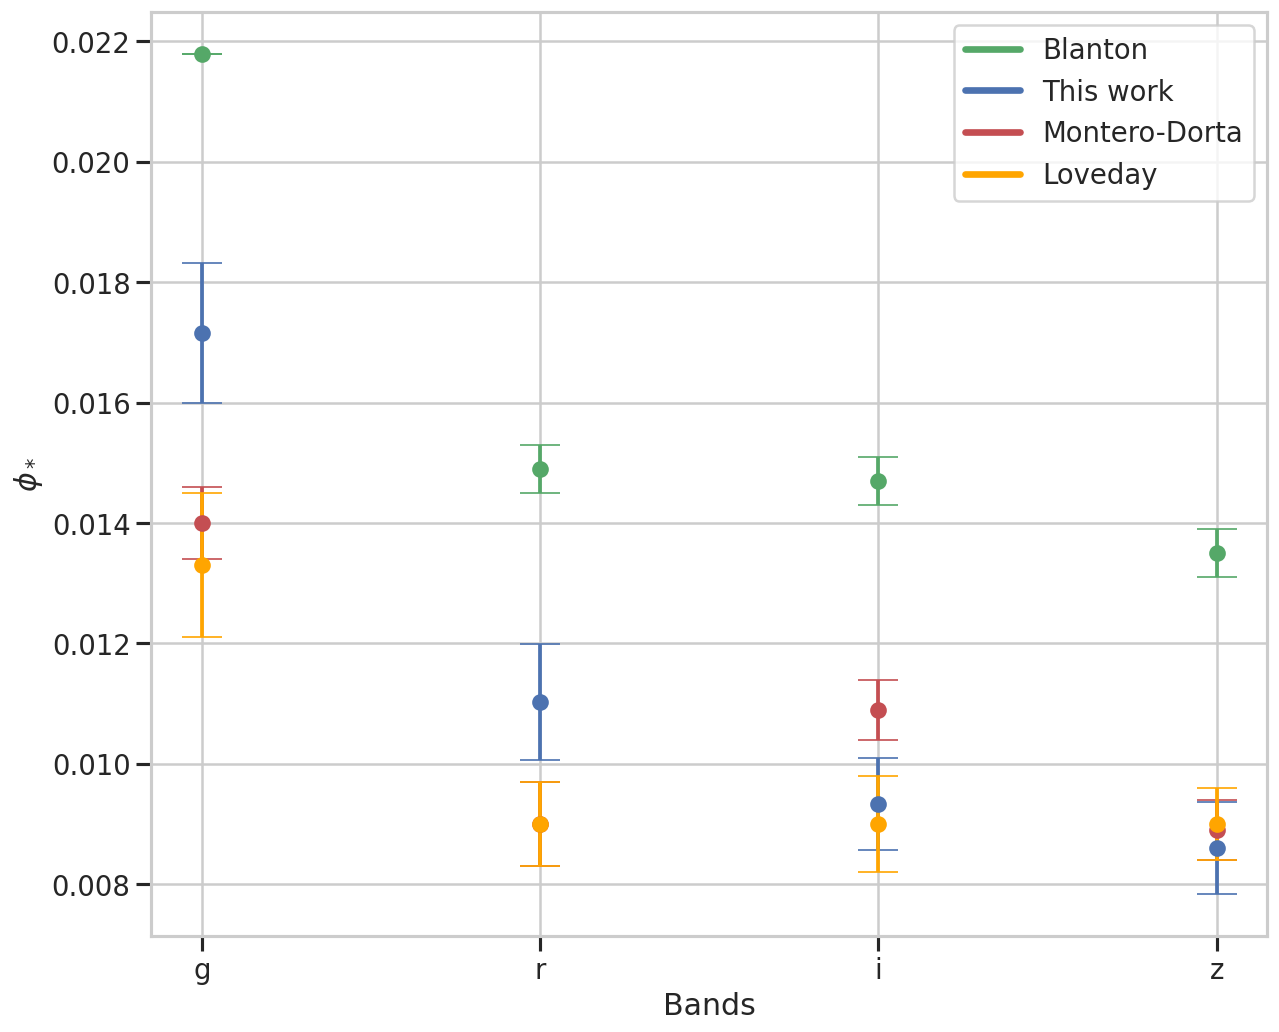

In [ ]:
#Parameter comparison, change v for different parameters in (0,1,2) => (M*,alpha,phi)
#Phi should be compared only AFTER recomputation in the completeness section below
#As such, load the data from the code block below first
from matplotlib.lines import Line2D
v=2
fig,ax = plt.subplots(figsize=(12,10),dpi=120)
for i in range(4):
    #ax.errorbar(i,coeffs[i][v],yerr=stddiag[i][v],capsize=12,color='b',fmt='o')
    ax.errorbar(i,ceor[:,i][v],yerr=siar[:,i][v],capsize=12,color='b',fmt='o')
    ax.errorbar(i,blan_coeffs[i][v],yerr=blan_stddiag[i][v],capsize=12,color='g',fmt='o')
    ax.errorbar(i,prada_coeffs[i][v],yerr=prada_stddiag[i][v],capsize=12,color='r',fmt='o')
    ax.errorbar(i,love_coeffs[i][v],yerr=love_stddiag[i][v],capsize=12,color='orange',fmt='o')

ax.set_xticks(ticks=[0,1,2,3],labels=['g','r','i','z'])

ax.set_xlabel('Bands')
ax.set_ylabel(r'$\phi_*$')

legelm = [Line2D([0], [0], color='g', lw=4, label='Blanton'),
          Line2D([0], [0], color='b', lw=4, label='This work'),
          Line2D([0], [0], color='r', lw=4, label='Montero-Dorta'),
          Line2D([0], [0], color='orange', lw=4, label='Loveday')]
ax.legend(handles=legelm)
plt.show()

In [ ]:
#writing results
data = [coeffs[0],stddiag[0],coeffs[1],stddiag[1],coeffs[2],stddiag[2],coeffs[3],stddiag[3],Mmin,Mmax]
pad_data = np.full((len(data),max(len(row) for row in data)),np.nan)
for i, row in enumerate(data):
    pad_data[i, :len(row)] = row

np.savetxt('Results/DESY3_z_02_22.txt',pad_data,fmt='%.6e', header='The Schechter function was fitted to an averaged function of the combination of all sky areas. This was chosen over fitting to sky areas then averaging the resulting coefficients because it yielded better and more reasonable results. The coefficients are in the order M_star, alpha, phi respectively, with the following line containing their standard deviation. Last two lines contain information on minimum and maximum values of absolute magnitude in range of fitting the function. Ordering: sch_coeff_g, sch_err_g, sch_coeff_r, sch_err_r, sch_coeff_i, sch_err_i, sch_coeff_z, sch_err_z, Mmin, Mmax (g,r,i,z in order for the last two)')

### Completeness and Predicted Galaxy Number

In [ ]:
# Defining/loading all Schechter parameters

vals = np.genfromtxt('Results/DESY3_z_02_22.txt')
coeffs = vals[0:8:2,0:3]
stddiag = vals[1:9:2,0:3]
Mmax = vals[9]
Mmin = vals[8]

blan_coeffs = [np.array([-19.39, -0.89, 2.18e-2]),np.array([-20.44, -1.05, 1.49e-2]),np.array([-20.82, -1.0, 1.47e-2]),np.array([-21.18, -1.08, 1.35e-2])]
blan_stddiag = [[0.02, 0.03, 0.04e-8],[0.01, 0.01, 0.04e-2],[0.02, 0.02, 0.04e-2],[0.02, 0.02, 0.04e-2]]

prada_coeffs = [np.array([-19.53, -1.10, 1.40e-2]),np.array([-20.73, -1.23, 0.90e-2]),np.array([-20.97, -1.16, 1.09e-2]),np.array([-21.43, -1.26, 0.89e-2])]
prada_stddiag = [[0.04, 0.02, 0.06e-2],[0.04, 0.02, 0.07e-2],[0.03, 0.02, 0.05e-2],[0.04, 0.03, 0.05e-2]]

love_coeffs = [np.array([-19.71, -1.20, 1.33e-2]),np.array([-20.73, -1.26, 0.9e-2]),np.array([-21.13, -1.22, 0.9e-2]),np.array([-21.41, -1.18, 0.9e-2])]
love_stddiag = [[0.02, 0.01, 0.12e-2],[0.03, 0.02, 0.07e-2],[0.02, 0.01, 0.08e-2],[0.05, 0.03, 0.06e-2]]

In [ ]:
# By using the Schechter parameters, we estimate the number of galaxies ina given luminosity and redshift range, then correct our amplitude to it

recomp = []
lval = 0.02
uval = 0.22
print(f'Recalibration from {lval} to {uval}')
for i in range(4):
    prednum = sp.integrate.quad(lambda x: func(x,*coeffs[i]),Mmax[i],Mmin[i])[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0.,uval)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0.,lval)[0])**3)
    zsel = (dist_z >lval) & (dist_z <=uval)
    redd_M = red_M[i][zsel]
    recomp.append(np.sum((redd_M>=Mmax[i]) & (redd_M<=Mmin[i]))/prednum)
    print(f'{bands[i]}-band')
    print(f'galaxy number estimated:',prednum)
    print(f'completeness estimated:',recomp[-1])
    print(fr'new $\phi_{bands[i]}$:',coeffs[i][2]*recomp[-1])
    print('\n')
ceor = np.array([coeffs[:,0],coeffs[:,1],recomp*(coeffs[:,2])])
siar = np.array([stddiag[:,0],stddiag[:,1],recomp*(coeffs[:,2]-stddiag[:,2])-recomp*(coeffs[:,2])])

Recalibration from 0.02 to 0.22
g-band
galaxy number estimated: 223823.43312908272
completeness estimated: 13.185853503989165
new $\phi_g$: 0.01715960824521886


r-band
galaxy number estimated: 214273.53554348412
completeness estimated: 13.554721037449745
new $\phi_r$: 0.011033887214398444


i-band
galaxy number estimated: 211479.8119854651
completeness estimated: 13.543136685769554
new $\phi_i$: 0.009332519963303388


z-band
galaxy number estimated: 206933.03423579017
completeness estimated: 13.544961587941687
new $\phi_z$: 0.008603129759946721




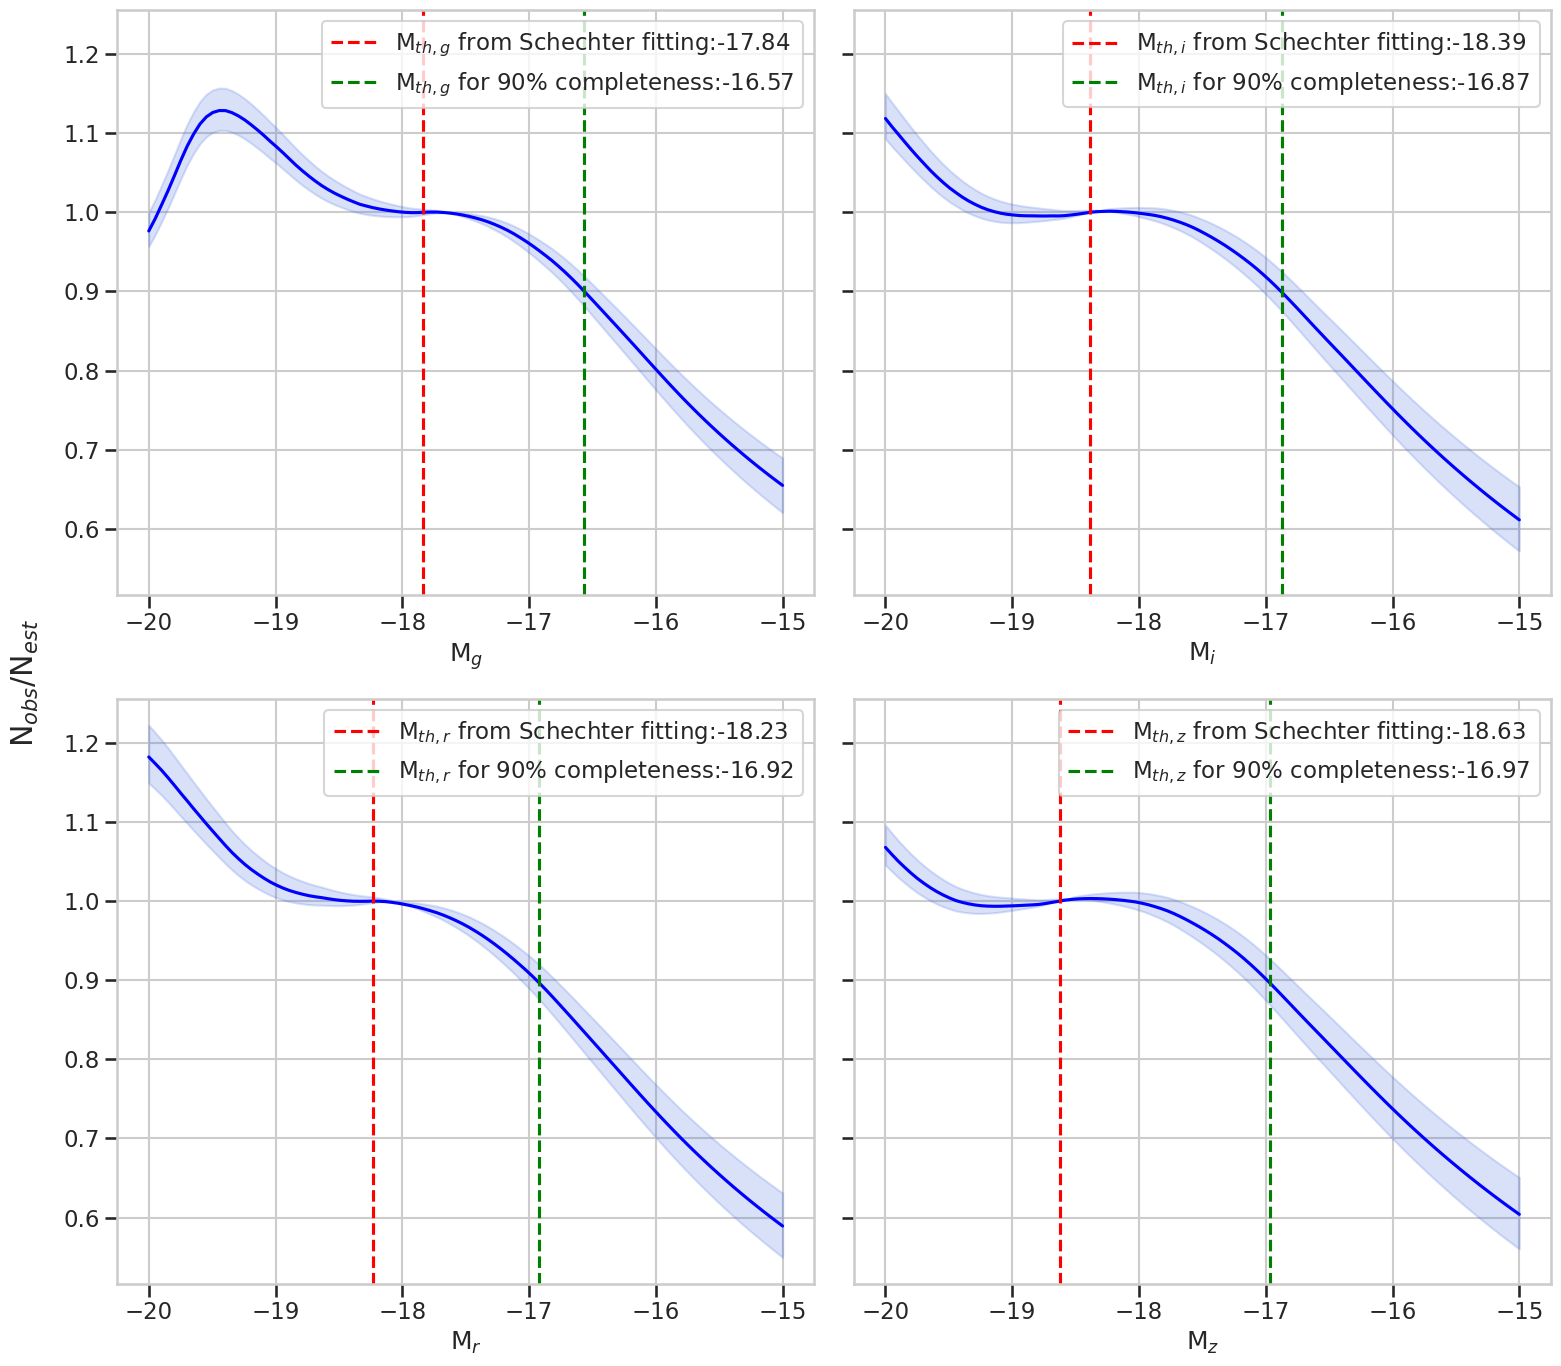

In [ ]:
#Change in completeness across M by playing with the faint-end M limit

redsel = (dist_z <= uval) & (dist_z > lval)
Mlist = np.linspace(-20,-15,100)

fig,ax = plt.subplots(figsize=(16,14),dpi=100,nrows=2,ncols=2,sharey=True)
ro = [0,1,0,1]
co = [0,0,1,1]
Mlow =[]
Mlowup =[]
Mlowlo =[]
for k in range(4):
    redd_M = red_M[k][redsel.tolist()]
    Mcomp=[]
    Mcompup=[]
    Mcomplo=[]
    
    for i in Mlist:
        nest = sp.integrate.quad(lambda x: func(x,*ceor[:,k]),Mmax[k],i)[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,uval)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,lval)[0])**3)
        nestup = sp.integrate.quad(lambda x: func(x,*ceor[:,k]+siar[:,k]),Mmax[k],i)[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,uval)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,lval)[0])**3)
        nestlo = sp.integrate.quad(lambda x: func(x,*ceor[:,k]-siar[:,k]),Mmax[k],i)[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,uval)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,lval)[0])**3)
        Mcomp.append(np.sum((redd_M>=Mmax[k]) & (redd_M<=i))/nest)
        Mcompup.append(np.sum((redd_M>=Mmax[k]) & (redd_M<=i))/nestup)
        Mcomplo.append(np.sum((redd_M>=Mmax[k]) & (redd_M<=i))/nestlo)
    
    Mcomp=np.array(Mcomp)
    Mcompup=np.array(Mcompup)
    Mcomplo=np.array(Mcomplo)
    
    Mth=Mlist[(Mcomp>0.89) & (Mcomp<0.901)][0]
    Mthup=Mlist[(Mcompup>0.89) & (Mcompup<0.901)][0]
    Mthlo=Mlist[(Mcomplo>0.89) & (Mcomplo<0.901)][0]
    Mlow.append(Mth)
    Mlowup.append(Mthup)
    Mlowlo.append(Mthlo)
    
    ax[ro[k]][co[k]].plot(Mlist,Mcomp,color='blue')
    ax[ro[k]][co[k]].fill_between(Mlist,Mcompup,Mcomplo,alpha=0.2,where=(Mcompup<Mcomplo),color='royalblue')
    ax[ro[k]][co[k]].fill_between(Mlist,Mcompup,Mcomplo,alpha=0.2,where=(Mcompup>Mcomplo),color='royalblue')
    ax[ro[k]][co[k]].set_xlabel(f'M$_{bands[k]}$')
    ax[ro[k]][co[k]].axvline(Mmin[k],color='red',ls='--',label=f'M$_{{th,{bands[k]}}}$ from Schechter fitting:{Mmin[k]:.2f}')
    ax[ro[k]][co[k]].axvline(Mth,color='green',ls='--',label=f'M$_{{th,{bands[k]}}}$ for 90% completeness:{Mth:.2f}')
    ax[ro[k]][co[k]].legend(loc='upper right')
fig.supylabel('N$_{obs}$/N$_{est}$')
fig.tight_layout()
fig.savefig('/home/ygence/scratch/comprange.png')
plt.show()
Mlows.append(Mlow)
Mlowsup.append(Mlowup)
Mlowslo.append(Mlowlo)

### Completeness for Redshift Bins from Other Results

In [4]:
rfile = h5py.File('/shares/soares-santos.physik.uzh/catalogs/valid_sample_des/des_y3_gold_galaxies.hdf5','r')
zlim = (rfile['z'][:] > 0.) & (rfile['z'][:] <= 0.5)
print(rfile['z'][zlim].shape)

dist_z = rfile['z'][zlim]

redm_g = rfile['m_g'][zlim]
redm_r = rfile['m_r'][zlim]
redm_i = rfile['m_i'][zlim]
redm_z = rfile['m_z'][zlim]

redmag = decam_to_sdss(redm_g, redm_r, redm_i, redm_z)

red_M = absmag(dist_z,redmag[0],redmag[1],redmag[2],redmag[3])

(45857703,)


In [ ]:
#Loading values for all ranges

vals = np.genfromtxt('Results/DESY3_z_1.txt')
coeffs1 = vals[0:8:2,0:3]
stddiag1 = vals[1:9:2,0:3]
Mmax1 = vals[9]
Mmin1 = vals[8]

vals = np.genfromtxt('Results/DESY3_z_2.txt')
coeffs2 = vals[0:8:2,0:3]
stddiag2 = vals[1:9:2,0:3]
Mmax2 = vals[9]
Mmin2 = vals[8]

vals = np.genfromtxt('Results/DESY3_z_3.txt')
coeffs3 = vals[0:8:2,0:3]
stddiag3 = vals[1:9:2,0:3]
Mmax3 = vals[9]
Mmin3 = vals[8]

vals = np.genfromtxt('Results/DESY3_z_4.txt')
coeffs4 = vals[0:8:2,0:3]
stddiag4 = vals[1:9:2,0:3]
Mmax4 = vals[9]
Mmin4 = vals[8]

vals = np.genfromtxt('Results/DESY3_z_5.txt')
coeffs5 = vals[0:8:2,0:3]
stddiag5 = vals[1:9:2,0:3]
Mmax5 = vals[9]
Mmin5 = vals[8]

coeffs = [coeffs1,coeffs2,coeffs3,coeffs4,coeffs5]
stddiag = [stddiag1,stddiag2,stddiag3,stddiag4,stddiag5]
Mmax = [Mmax1,Mmax2,Mmax3,Mmax4,Mmax5]
Mmin = [Mmin1,Mmin2,Mmin3,Mmin4,Mmin5]
rrange = np.array([0,0.1,0.2,0.3,0.4,0.5])

In [ ]:
# Same phi recomputation as above, done for all the bins
ceo=[]
sia=[]
for m in range(5):
    
    recomp = []
    lval = rrange[m]
    uval = rrange[m+1]
    print(f'Recalibration from {lval} to {uval}')
    for i in range(4):
        prednum = sp.integrate.quad(lambda x: func(x,*coeffs[m][i]),Mmax[m][i],Mmin[m][i])[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0.,uval)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0.,lval)[0])**3)
        zsel = (dist_z >lval) & (dist_z <=uval)
        redd_M = red_M[i][zsel]
        recomp.append(np.sum((redd_M>=Mmax[m][i]) & (redd_M<=Mmin[m][i]))/prednum)
        print(f'{bands[i]}-band')
        print(f'galaxy number estimated:',prednum)
        print(f'completeness estimated:',recomp[-1])
        print(fr'new $\phi_{bands[i]}$:',coeffs[m][i][2]*recomp[-1])
        print('\n')
    ceor = np.array([coeffs[m][:,0],coeffs[m][:,1],recomp*(coeffs[m][:,2])])
    siar = np.array([stddiag[m][:,0],stddiag[m][:,1],recomp*(coeffs[m][:,2]-stddiag[m][:,2])-recomp*(coeffs[m][:,2])])
    ceo.append(ceor)
    sia.append(siar)

Recalibration from 0.0 to 0.1
g-band
galaxy number estimated: 32558.0984161525
completeness estimated: 13.297858937154828
new $\phi_g$: 0.02460715604884752


r-band
galaxy number estimated: 32065.891380199053
completeness estimated: 13.457726619334704
new $\phi_r$: 0.018126602257653873


i-band
galaxy number estimated: 35041.31054864474
completeness estimated: 13.559681203715051
new $\phi_i$: 0.014752987388366792


z-band
galaxy number estimated: 35525.26089688227
completeness estimated: 13.597620054139947
new $\phi_z$: 0.013091406495002421


Recalibration from 0.1 to 0.2
g-band
galaxy number estimated: 181903.47296118375
completeness estimated: 13.294864362023791
new $\phi_g$: 0.016545764480418935


r-band
galaxy number estimated: 165510.55119434212
completeness estimated: 13.345263997136069
new $\phi_r$: 0.011922217126803058


i-band
galaxy number estimated: 165542.49676458855
completeness estimated: 13.43093189636855
new $\phi_i$: 0.009535417693679868


z-band
galaxy number estimate

In [ ]:
#Sanity check
for m in range(5):
    lval = rrange[m]
    uval = rrange[m+1]
    print(f'\n Redshift range: {lval} to {uval}')
    for i in range(4):
        zsel = (dist_z >lval) & (dist_z <=uval)
        redd_M = red_M[i][zsel]
        obj_count = np.sum((redd_M>=Mmax[m][i]) & (redd_M<=Mmin[m][i]))
        estnum = sp.integrate.quad(lambda x: func(x,*ceo[m][:,i]),Mmax[m][i],Mmin[m][i])[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0.,uval)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0.,lval)[0])**3)
        print(bands[i])
        print('estimated galaxy number:',estnum)
        print('actual galaxy number:',obj_count)
        rer = obj_count/estnum
        print('completeness fraction:',rer)


 Redshift range: 0.0 to 0.1
g
estimated galaxy number: 432953.0
actual galaxy number: 432953
completeness fraction: 1.0
r
estimated galaxy number: 431534.0
actual galaxy number: 431534
completeness fraction: 1.0
i
estimated galaxy number: 475148.99999999994
actual galaxy number: 475149
completeness fraction: 1.0000000000000002
z
estimated galaxy number: 483059.0000034393
actual galaxy number: 483059
completeness fraction: 0.9999999999928801

 Redshift range: 0.1 to 0.2
g
estimated galaxy number: 2418382.0000000005
actual galaxy number: 2418382
completeness fraction: 0.9999999999999998
r
estimated galaxy number: 2208782.0
actual galaxy number: 2208782
completeness fraction: 1.0
i
estimated galaxy number: 2223390.0
actual galaxy number: 2223390
completeness fraction: 1.0
z
estimated galaxy number: 2295690.0
actual galaxy number: 2295690
completeness fraction: 1.0

 Redshift range: 0.2 to 0.3
g
estimated galaxy number: 3954907.9999999995
actual galaxy number: 3954908
completeness fractio

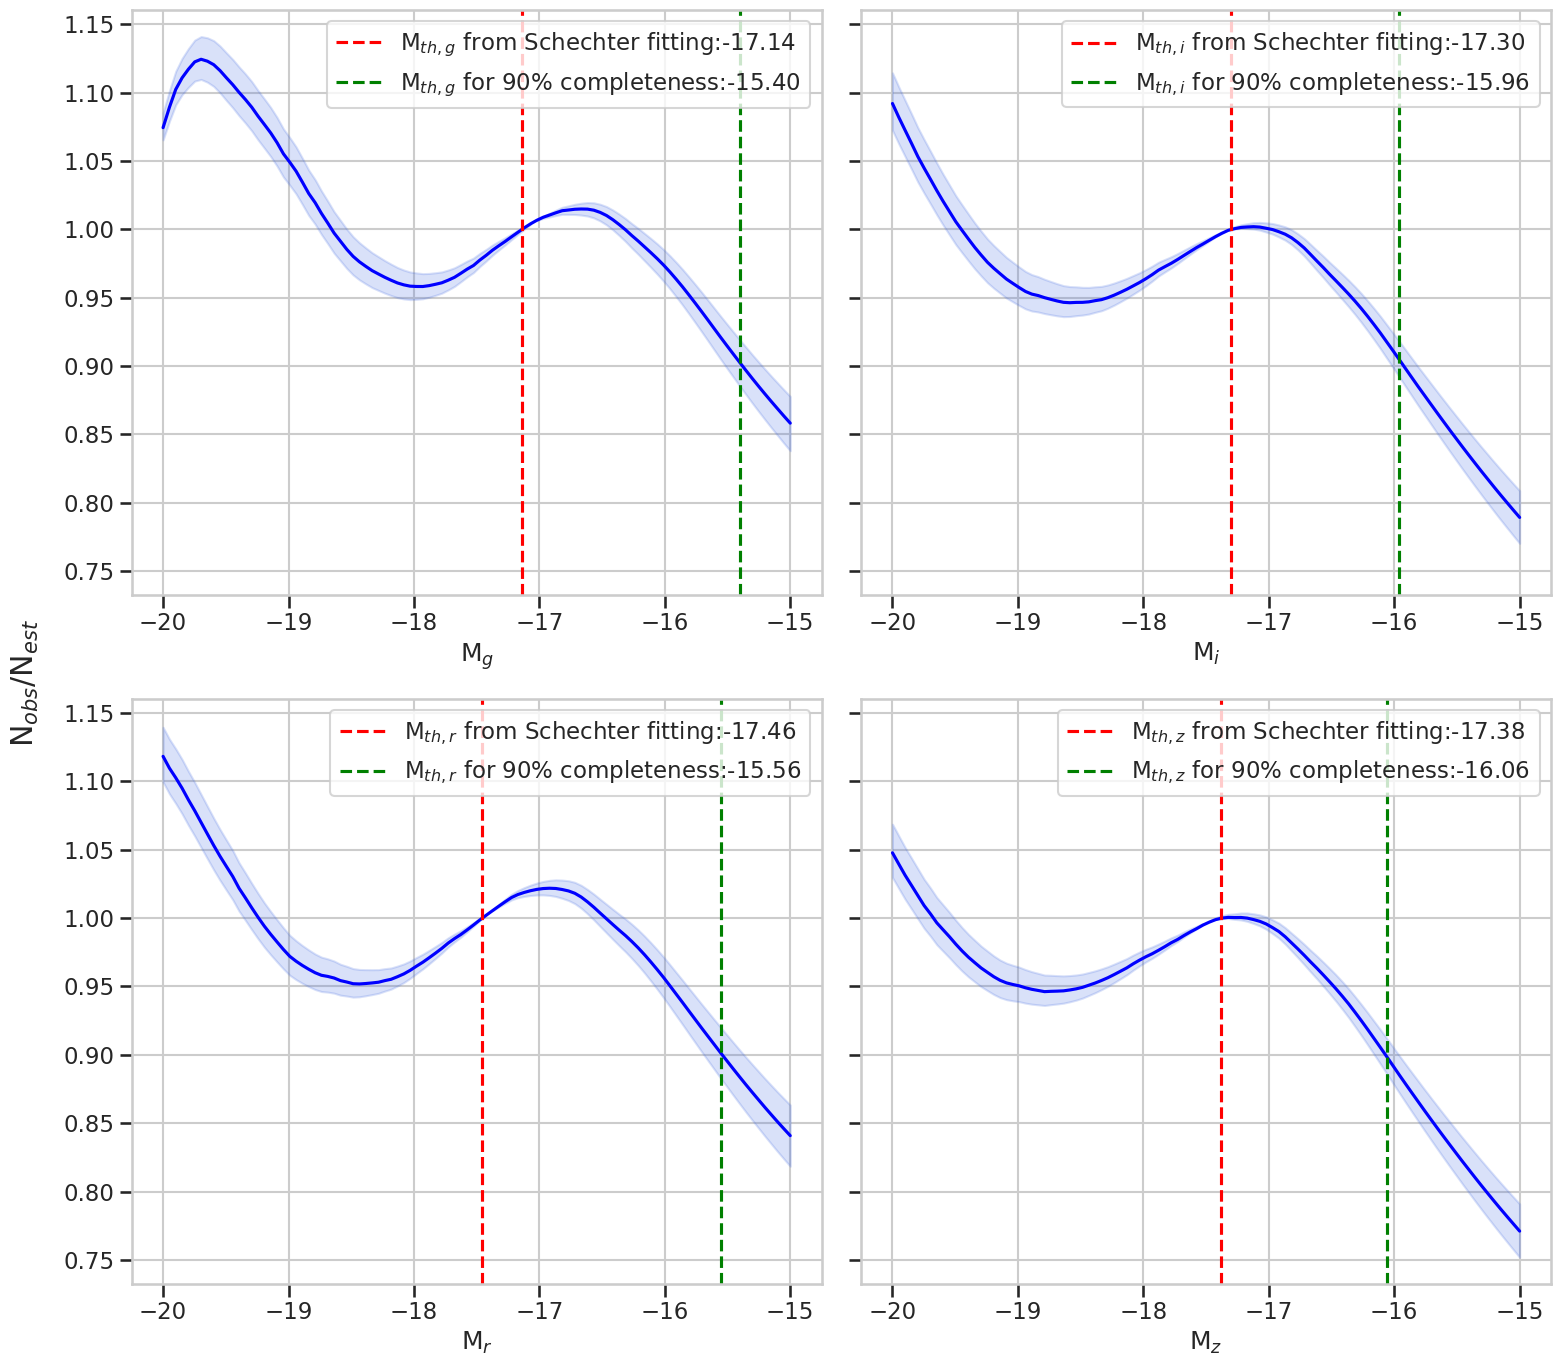

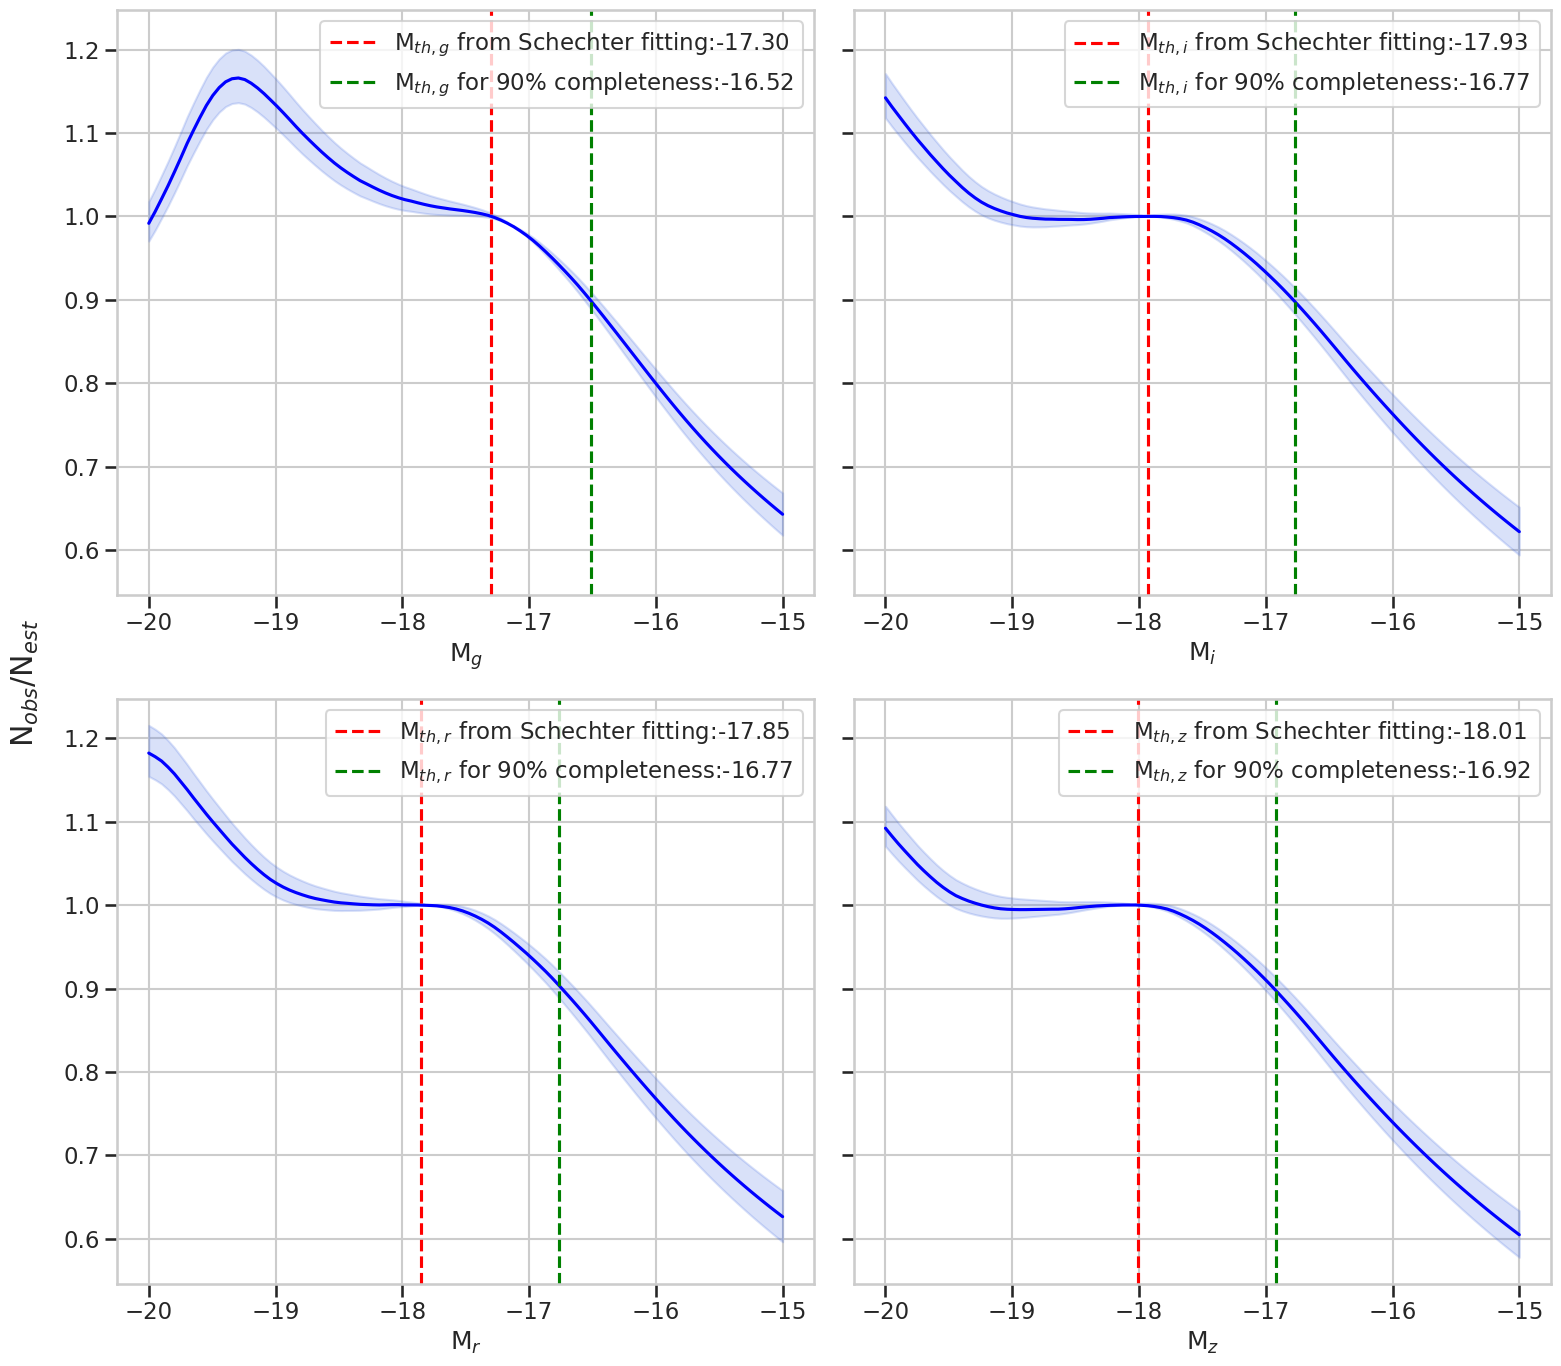

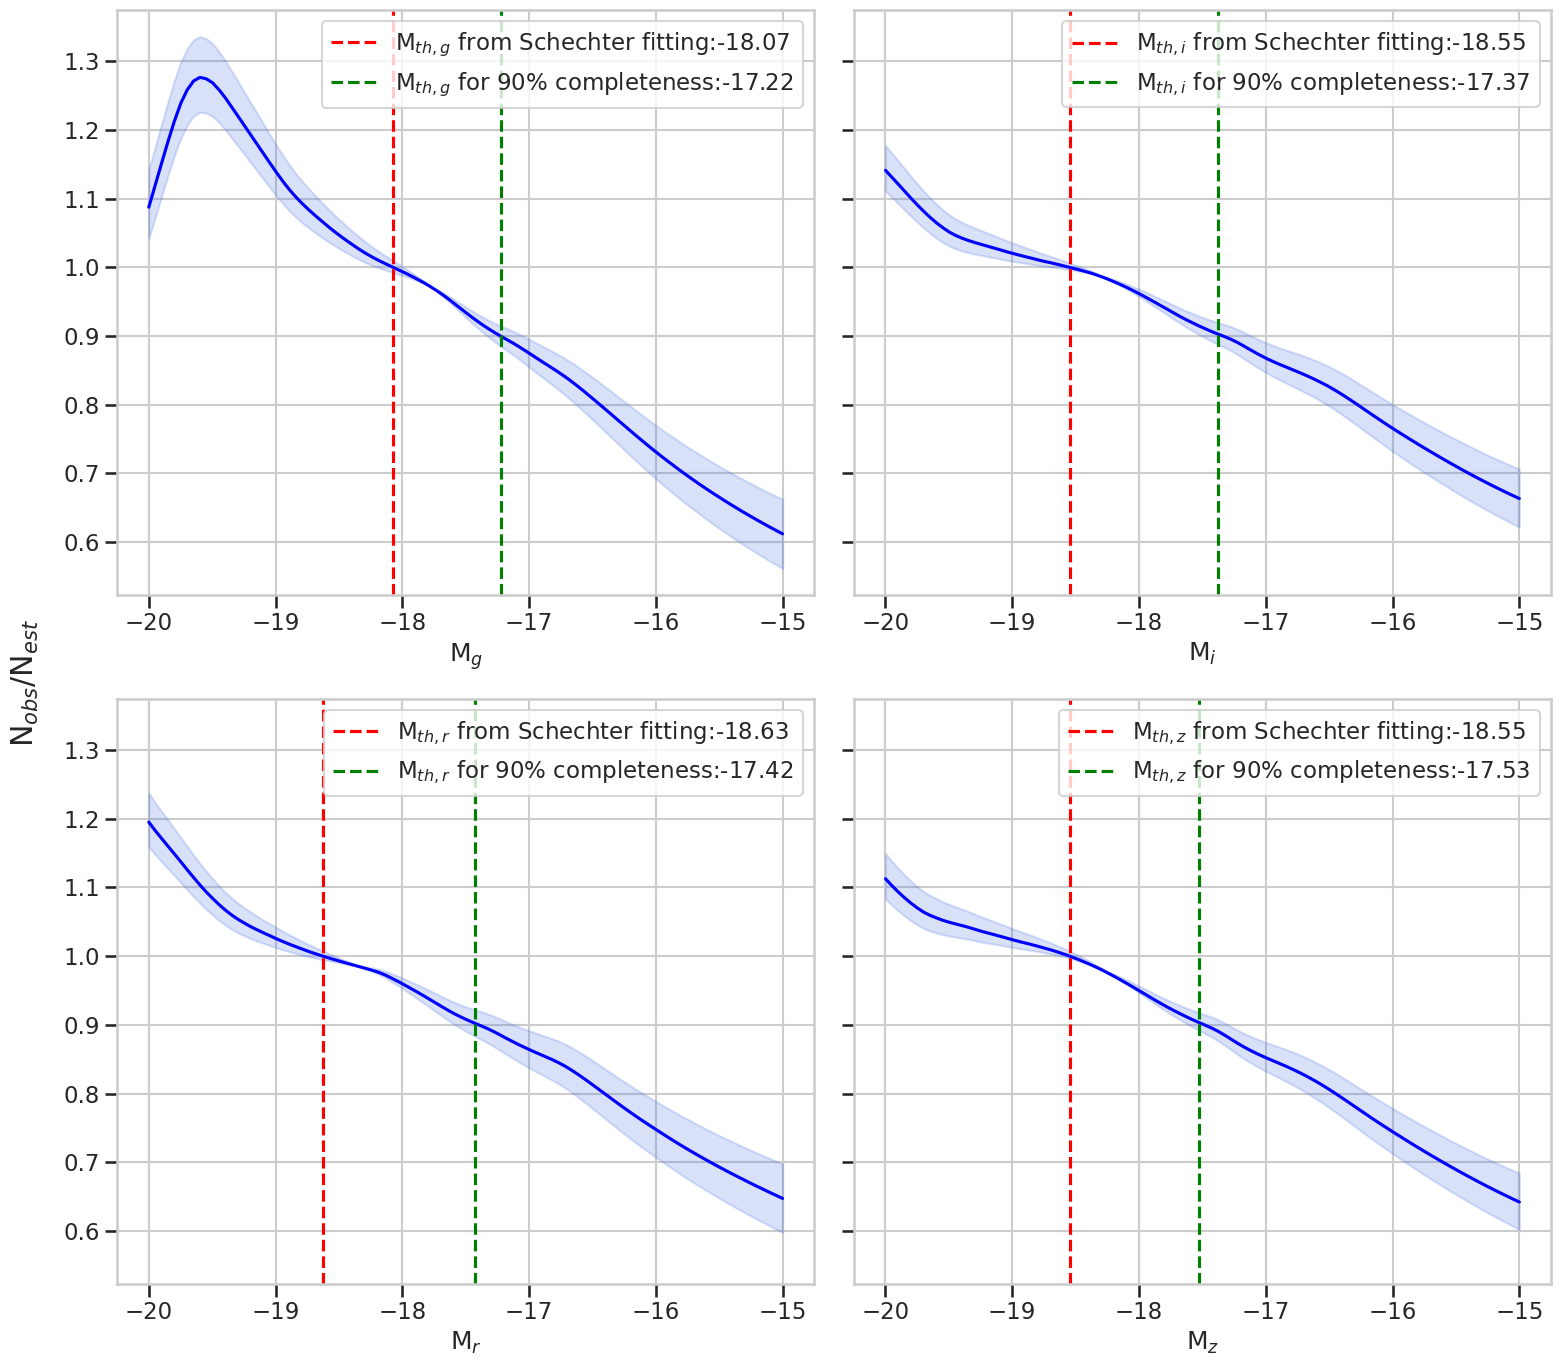

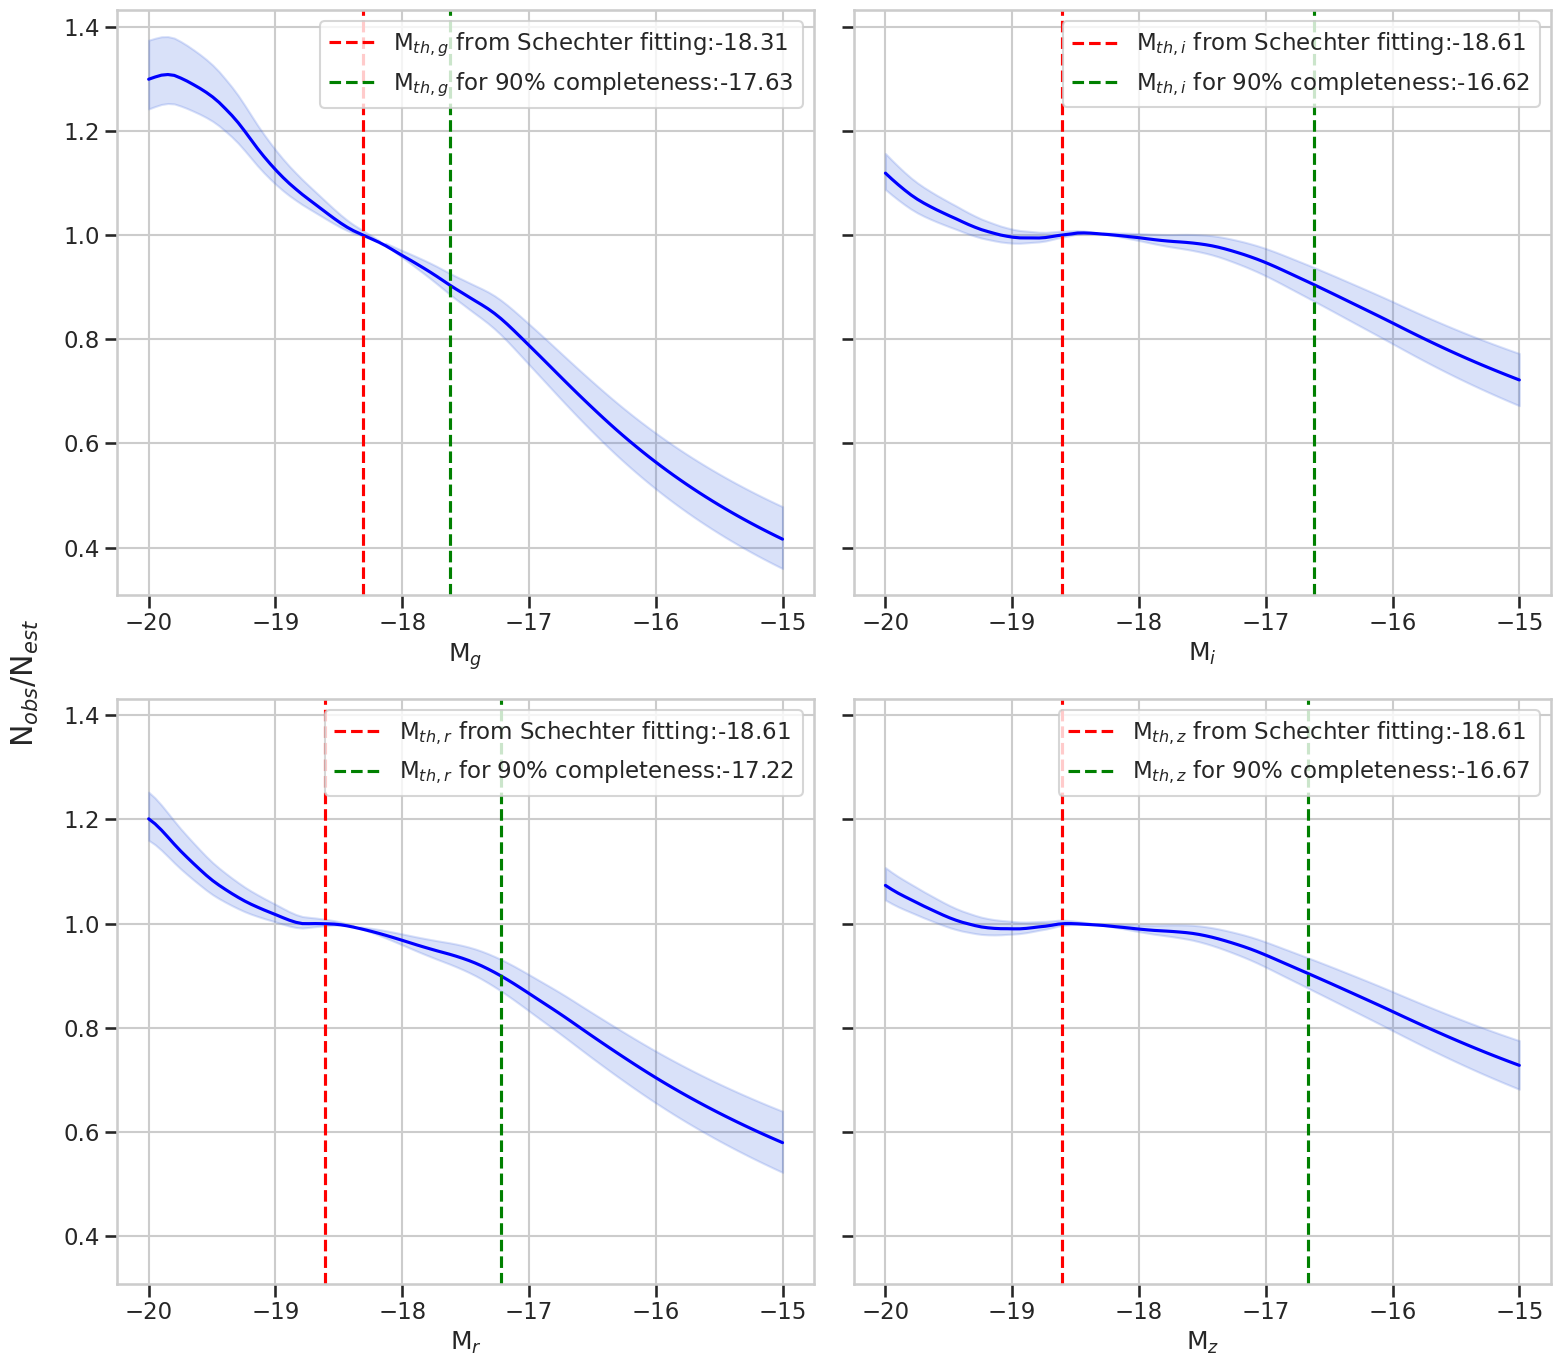

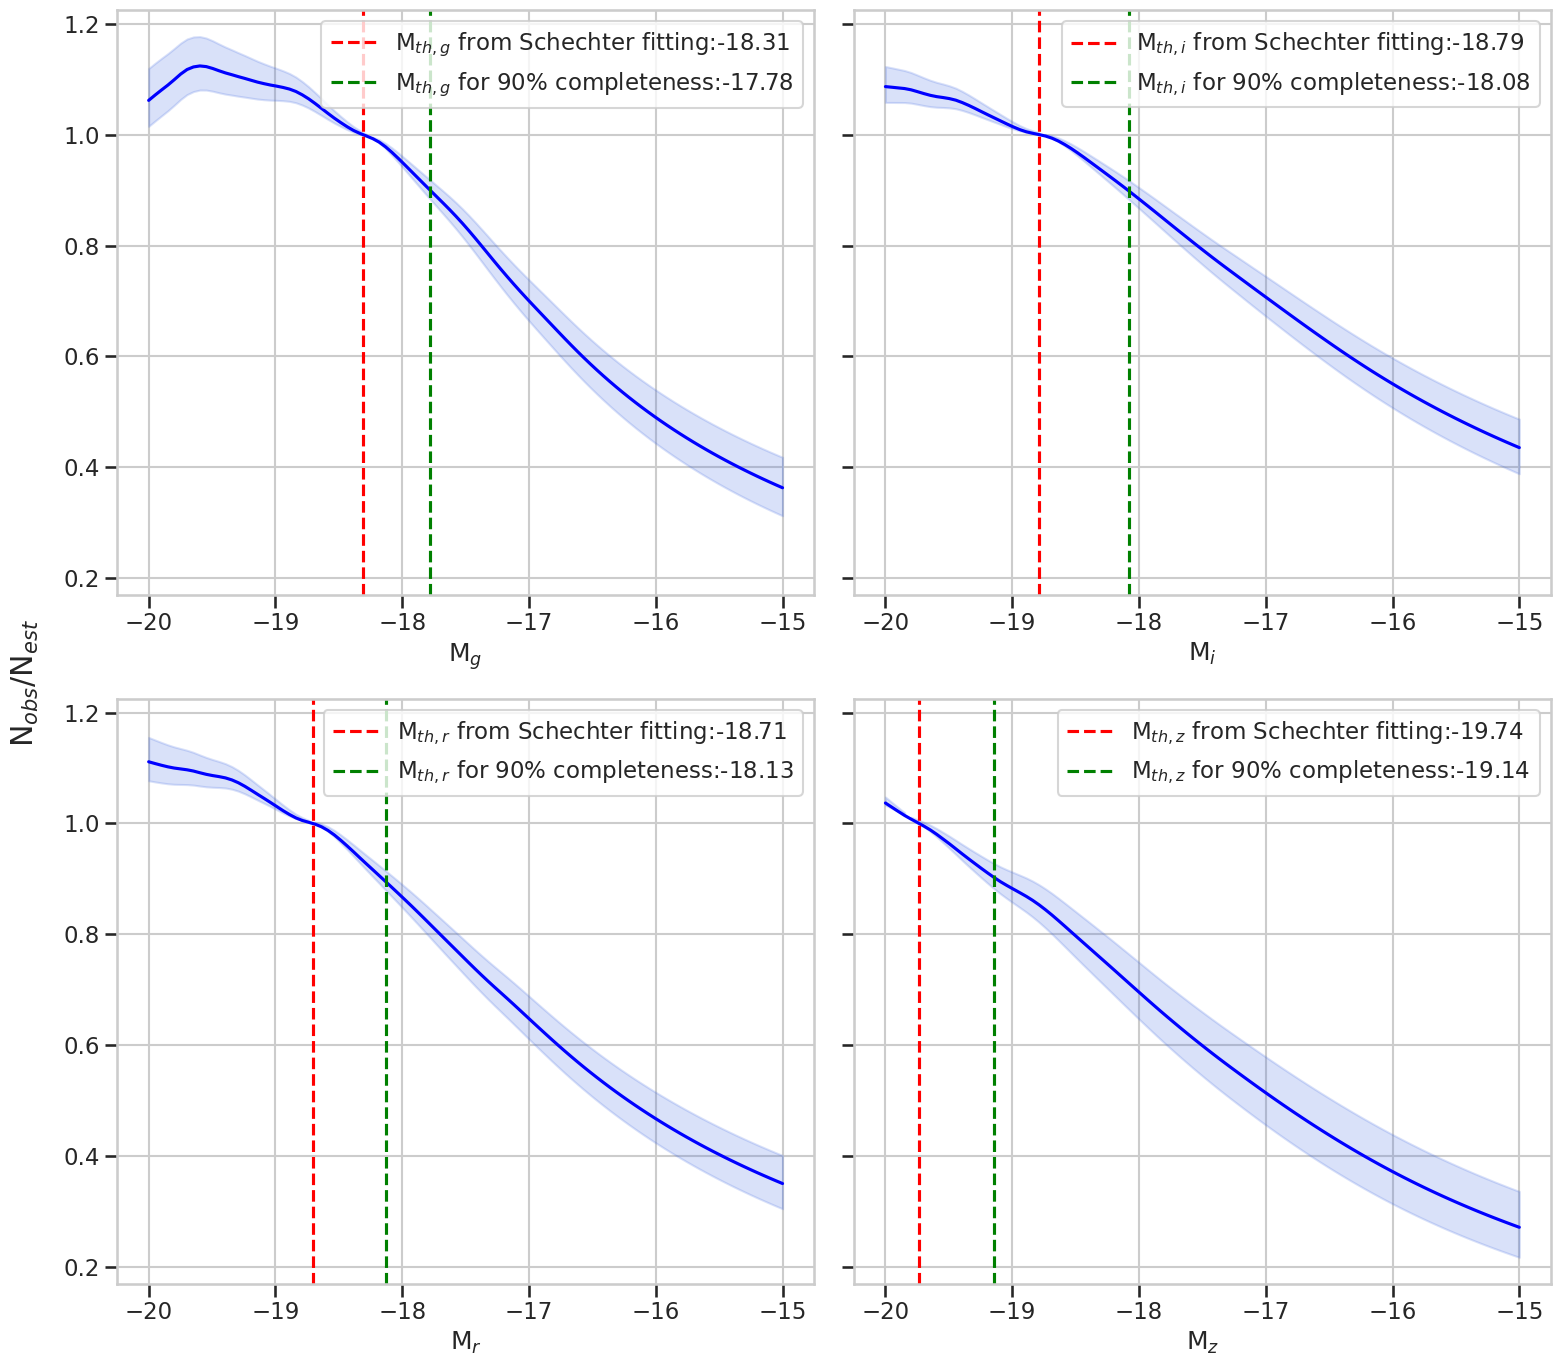

In [ ]:
# Completeness change in faint-end M.

Mlows=[]
Mlowsup=[]
Mlowslo=[]
for m in range(5):

    lval = rrange[m]
    uval = rrange[m+1]

    redsel = (dist_z <= uval) & (dist_z > lval)
    Mlist = np.linspace(-20,-15,100)
    
    fig,ax = plt.subplots(figsize=(16,14),dpi=100,nrows=2,ncols=2,sharey=True)
    ro = [0,1,0,1]
    co = [0,0,1,1]
    Mlow =[]
    Mlowup =[]
    Mlowlo =[]
    for k in range(4):
        redd_M = red_M[k][redsel.tolist()]
        Mcomp=[]
        Mcompup=[]
        Mcomplo=[]
        
        for i in Mlist:
            nest = sp.integrate.quad(lambda x: func(x,*ceo[m][:,k]),Mmax[m][k],i)[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,uval)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,lval)[0])**3)
            nestup = sp.integrate.quad(lambda x: func(x,*ceo[m][:,k]+sia[m][:,k]),Mmax[m][k],i)[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,uval)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,lval)[0])**3)
            nestlo = sp.integrate.quad(lambda x: func(x,*ceo[m][:,k]-sia[m][:,k]),Mmax[m][k],i)[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,uval)[0])**3 - (sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,lval)[0])**3)
            Mcomp.append(np.sum((redd_M>=Mmax[m][k]) & (redd_M<=i))/nest)
            Mcompup.append(np.sum((redd_M>=Mmax[m][k]) & (redd_M<=i))/nestup)
            Mcomplo.append(np.sum((redd_M>=Mmax[m][k]) & (redd_M<=i))/nestlo)
        
        Mcomp=np.array(Mcomp)
        Mcompup=np.array(Mcompup)
        Mcomplo=np.array(Mcomplo)
        
        Mth=Mlist[(Mcomp>0.89) & (Mcomp<0.905)][0]
        Mthup=Mlist[(Mcompup>0.89) & (Mcompup<0.905)][0]
        Mthlo=Mlist[(Mcomplo>0.89) & (Mcomplo<0.905)][0]
        Mlow.append(Mth)
        Mlowup.append(Mthup)
        Mlowlo.append(Mthlo)
        
        ax[ro[k]][co[k]].plot(Mlist,Mcomp,color='blue')
        ax[ro[k]][co[k]].fill_between(Mlist,Mcompup,Mcomplo,alpha=0.2,where=(Mcompup<Mcomplo),color='royalblue')
        ax[ro[k]][co[k]].fill_between(Mlist,Mcompup,Mcomplo,alpha=0.2,where=(Mcompup>Mcomplo),color='royalblue')
        ax[ro[k]][co[k]].set_xlabel(f'M$_{bands[k]}$')
        ax[ro[k]][co[k]].axvline(Mmin[m][k],color='red',ls='--',label=f'M$_{{th,{bands[k]}}}$ from Schechter fitting:{Mmin[m][k]:.2f}')
        ax[ro[k]][co[k]].axvline(Mth,color='green',ls='--',label=f'M$_{{th,{bands[k]}}}$ for 90% completeness:{Mth:.2f}')
        ax[ro[k]][co[k]].legend(loc='upper right')
    fig.supylabel('N$_{obs}$/N$_{est}$')
    fig.tight_layout()
    plt.show()
    Mlows.append(Mlow)
    Mlowsup.append(Mlowup)
    Mlowslo.append(Mlowlo)

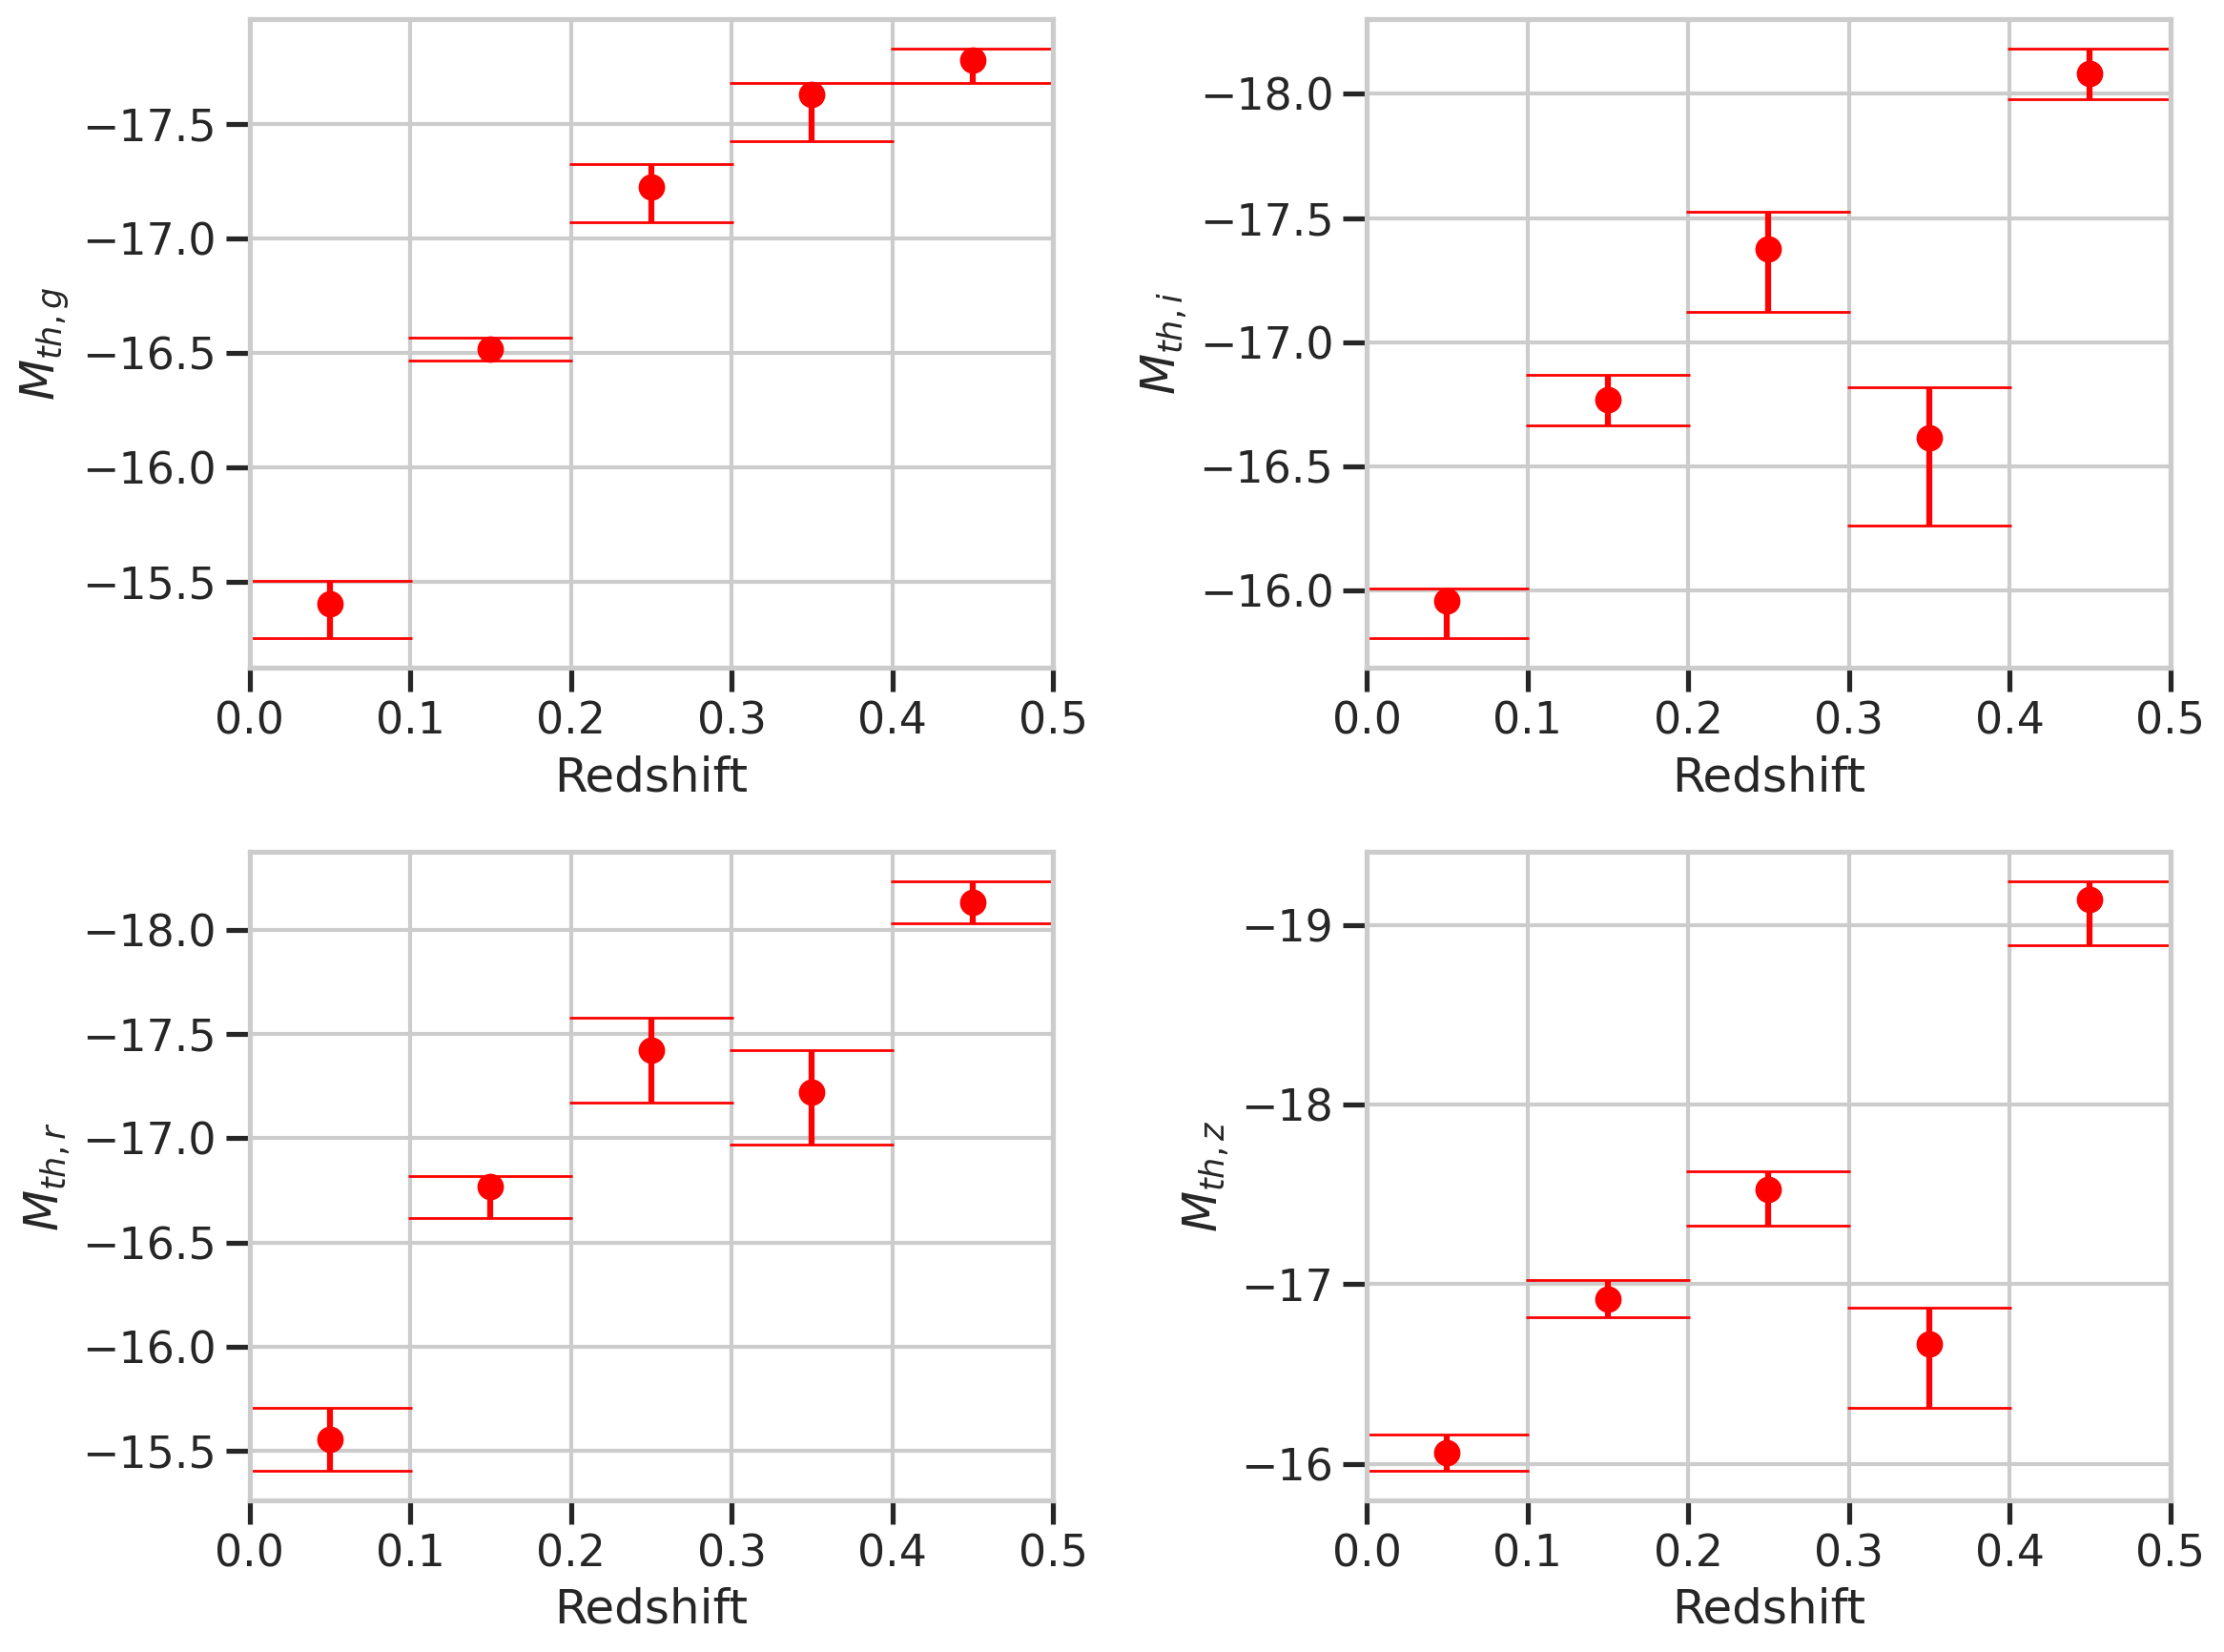

In [ ]:
#Change in 90% completeness M_th values

fig,ax = plt.subplots(figsize=(12,9),dpi=200,nrows=2,ncols=2,sharex=False,sharey=False)
ro = [0,1,0,1]
co = [0,0,1,1]
mplots=[]
mplotsup=[]
mplotslo=[]

for i in range(4):
    mplot=[]
    mplotup=[]
    mplotlo=[]
    for m in range(5):
        mplot.append(Mlows[m][i])
        mplotup.append(Mlowsup[m][i])
        mplotlo.append(Mlowslo[m][i])
    mplots.append(mplot)
    mplotsup.append(mplotup)
    mplotslo.append(mplotlo)
    
    ax[ro[i]][co[i]].errorbar((rrange[1:]+rrange[:-1])/2,mplot,yerr=[np.array(mplot)-np.array(mplotlo),np.array(mplotup)-np.array(mplot)],fmt='o',ls='none',color='red',capsize=31)
    ax[ro[i]][co[i]].set_ylabel(fr'$M_{{th,{bands[i]}}}$')
    ax[ro[i]][co[i]].set_xlabel('Redshift')
    ax[ro[i]][co[i]].set_xlim(0,0.5)
    ax[ro[i]][co[i]].invert_yaxis()
fig.tight_layout()
plt.show()

In [ ]:
#Completeness calculation across the redshift range, using 90% M_th value, with deviation values

completeness = []
upcompleteness = []
locompleteness = []

Nests = []
upNests = []
loNests = []

for m in range(10):
    lval = rrange[m]
    uval = rrange[m+1]
    
    redder = np.linspace(lval,uval,6)
    print(redder)
    for i in tqdm(range(len(redder)-1)):
        
        redsel = (dist_z <= redder[i+1]) & ((dist_z > redder[i]))
        redd_M = red_M[1][redsel.tolist()]
        
        Nest = sp.integrate.quad(lambda x: func(x,*ceo[m][:,1]),Mmax[m][1],Mlows[m][1])[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,redder[i+1])[0])**3 -(sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,redder[i])[0])**3)
        upNest = sp.integrate.quad(lambda x: func(x,*ceo[m][:,1]+sia[m][:,1]),Mmax[m][1],Mlows[m][1])[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,redder[i+1])[0])**3 -(sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,redder[i])[0])**3)
        loNest = sp.integrate.quad(lambda x: func(x,*ceo[m][:,1]-sia[m][:,1]),Mmax[m][1],Mlows[m][1])[0] * A * ((sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,redder[i+1])[0])**3 -(sch_c/H0 * sp.integrate.quad(lambda x: E(x),0,redder[i])[0])**3)
        
        comp=np.sum((redd_M>=Mmax[m][1]) & (redd_M<=Mlows[m][1]))/(Nest)
        Nests.append(Nest)
        completeness.append(comp)
        
        upcomp=np.sum((redd_M>=Mmax[m][1]) & (redd_M<=Mlows[m][1]))/(upNest)
        upNests.append(upNest)
        upcompleteness.append(upcomp)
        
        locomp=np.sum((redd_M>=Mmax[m][1]) & (redd_M<=Mlows[m][1]))/(loNest)
        loNests.append(loNest)
        locompleteness.append(locomp)
    
completeness = np.array(completeness)
upcompleteness = np.array(upcompleteness)
locompleteness = np.array(locompleteness)

[0.   0.01 0.02 0.03 0.04 0.05]


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


[0.05 0.06 0.07 0.08 0.09 0.1 ]


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


[0.1  0.11 0.12 0.13 0.14 0.15]


100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


[0.15 0.16 0.17 0.18 0.19 0.2 ]


100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


[0.2  0.21 0.22 0.23 0.24 0.25]


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


[0.25 0.26 0.27 0.28 0.29 0.3 ]


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


[0.3  0.31 0.32 0.33 0.34 0.35]


100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


[0.35 0.36 0.37 0.38 0.39 0.4 ]


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


[0.4  0.41 0.42 0.43 0.44 0.45]


100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


[0.45 0.46 0.47 0.48 0.49 0.5 ]


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


Text(0.5, 0, 'Redshift')

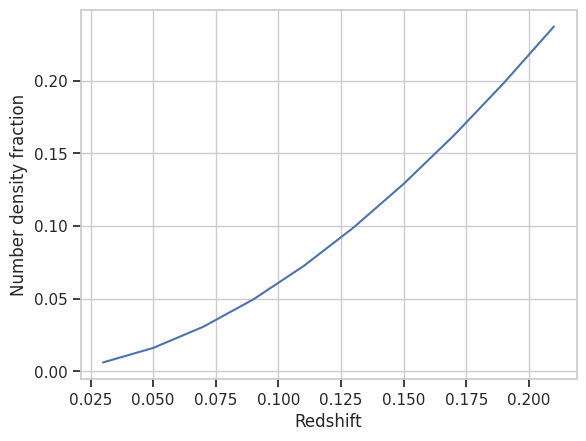

In [ ]:
# Percentage contribution to completeness for increasing number of objects
plt.plot((redder[1:]+redder[:-1])/2,Nests/np.sum(np.array(Nests)))
plt.ylabel('Number density fraction')
plt.xlabel('Redshift')

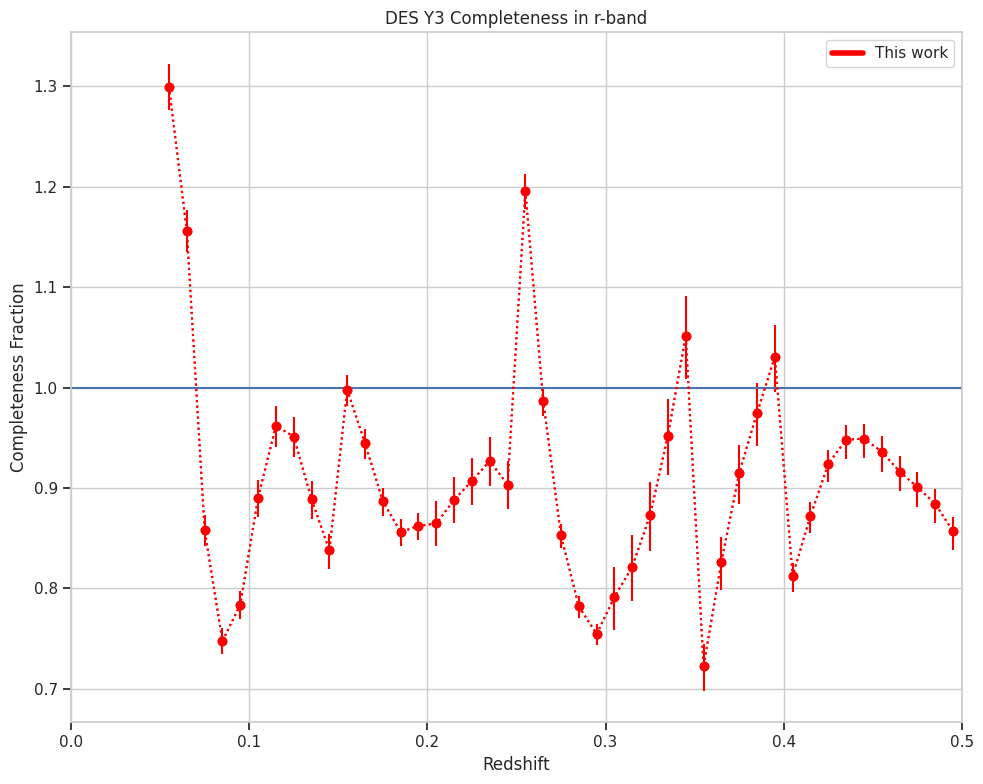

In [ ]:
#Completeness visualization in the r-band

from matplotlib.lines import Line2D
fig,ax = plt.subplots(figsize=(10,8),dpi=100)
reader = np.linspace(0,0.5,51)
reader = (reader[1:]+reader[:-1])/2
try:
    ax.errorbar(reader[5:],completeness[5:],yerr=[(completeness-upcompleteness)[5:],(locompleteness-completeness)[5:]],fmt='o',color='red',ls=':',capsize=0,label='This work')
except ValueError:
    ax.errorbar(reader[5:],completeness[5:],yerr=[(upcompleteness-completeness)[5:],(completeness-locompleteness)[5:]],fmt='o',color='red',ls=':',capsize=0,label='This work')

ax.axhline(1)
#ax.set_ylim(0.,1.05)
ax.set_xlim(0,0.5)

ax.set_ylabel('Completeness Fraction')
ax.set_xlabel('Redshift')
ax.set_title('DES Y3 Completeness in r-band')

legelm = [Line2D([0], [0], color='red', lw=4, label='This work')]

fig.tight_layout()
ax.legend(handles = legelm)
plt.show()

In [ ]:
# Center of Mass computation for dN/dz, as seen in the plot below
# Generously provided by Isaac McMahon

from scipy.interpolate import CubicSpline
O_m = 0.3065
O_l = 1-O_m

def comoving_distance(z_array, n_points=10):
    x = z_array[:, None] * np.linspace(0, 1, n_points)
    dx = z_array * 1./(n_points-1)
    y = (O_m*((1+x)**3)+O_l)**-0.5
    avg_y = (y[:,:-1]+y[:,1:])/2
    return np.sum(dx[:, np.newaxis]*avg_y, axis=1) * 299792.458 / H0

def comoving_volume(z, n_points=10):
    return 4.18879 * (comoving_distance(z, n_points)**3)

z_table = np.linspace(0, 2, 100000)
dc_table = comoving_distance(z_table, 1000)
vc_table = 4.18879 * (dc_table**3)
z_to_vc = CubicSpline(z_table, vc_table)
vc_to_z = CubicSpline(vc_table, z_table)

vc_max = z_to_vc(0.7)
choices = np.random.random(int(1e7)) * vc_max
uniform_gal_z = vc_to_z(choices)
hist, bin_edges = np.histogram(uniform_gal_z, bins=200, range=[0, 0.7])
interp_dn = CubicSpline(bin_edges[1:]-(bin_edges[1]-bin_edges[0]), hist/np.sum(hist))

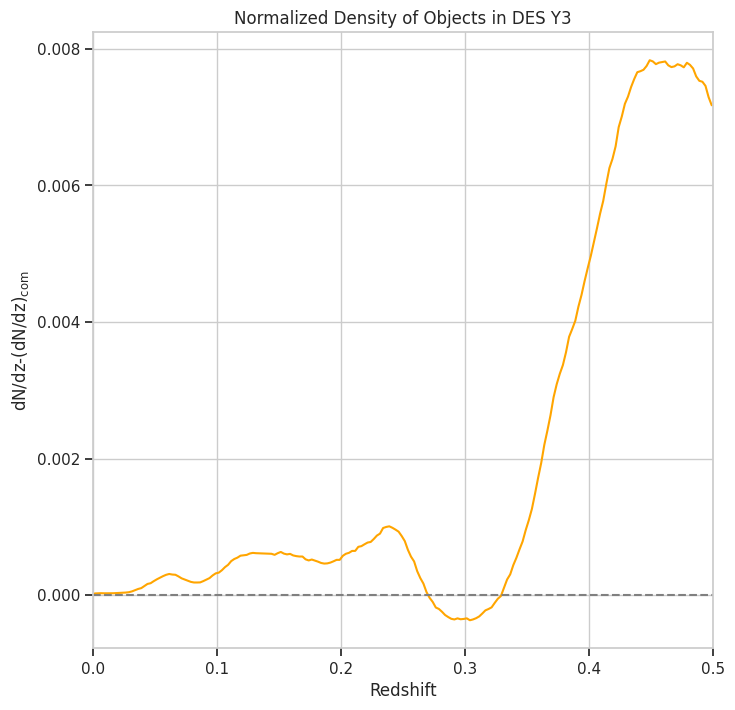

In [ ]:
a,b = np.histogram(dist_z,bins=200)
edges = 0.5*(b[1:]+b[:-1])
fig,ax = plt.subplots(figsize=(8,8),dpi=100)
ax.plot(edges,a/np.sum(a) - interp_dn(edges),color='orange')
ax.axhline(0,ls='--',color='gray')
ax.set_xlim(0,0.5)
ax.set_title('Normalized Density of Objects in DES Y3')
ax.set_xlabel('Redshift')
ax.set_ylabel(r'dN/dz-(dN/dz)$_{\text{com}}$')

plt.show()